## Import Library 导入库

In [1]:
import numpy as np 
import pandas as pd 
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os
import io
from scipy.stats import boxcox
from sklearn.utils import shuffle
from scipy.interpolate import make_interp_spline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import Counter
import re
import geopandas as gpd
from shapely.geometry import Point, box
from esda.getisord import G_Local
from libpysal.weights import DistanceBand
from sklearn.utils import resample
from scipy.stats import chi2_contingency, spearmanr
from pysal.lib import weights
from pysal.explore import esda
from esda.getisord import G as GetisOrd_Gi
from libpysal.weights import KNN
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.neighbors import BallTree
import optuna
import graphviz
from skopt import gp_minimize
from skopt.space import Integer, Categorical
from skopt.utils import use_named_args
from sklearn.inspection import PartialDependenceDisplay


# 低饱和度的颜色（RGBA格式）
colors = [
    (135/255, 206/255, 250/255, 0.6),  # skyblue
    (255/255, 165/255, 0/255, 0.6),    # orange
    (144/255, 238/255, 144/255, 0.6),  # lightgreen
    (250/255, 128/255, 114/255, 0.6)   # salmon
]

C:\Users\waitgreen\AppData\Roaming\Python\Python311\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


## 1. Data EDA and Preprocessing 数据探索性分析和预处理

### 1.1 Importing data sets 导入数据集

In [2]:
df = pd.read_csv('data/US_Accidents_March23.csv')
print("The shape of data is:",(df.shape))

The shape of data is: (7728394, 46)


### 1.2 数据预处理

- Data set descriptive information 数据集描述性信息

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

#### 1.2.1 删除一些无用的冗余信息
 - ID：并不关心每起交通事故的序号，其不提供有关事故本身的任何有用信息。
 - Source：数据源作者已经初步删除了不同数据源中可能包含重复的交通事故事件，因此这里认为每一起交通事故都是独立的，唯一的。因此数据源的信息也是多余的。
 - Description：由于数据源作者已经从每一起交通事故的描述中提取了POI特征，感兴趣的信息，于是这些详细的描述信息无法提供更多的分析价值。
 - End_Time，End_Lat和End_Lng：这些都是在事故发生之后才能收集得到的信息，因此对于交通事故的发生并无影响，所以删除。

In [4]:
df = df.drop(['ID', 'Source', 'Description', 'End_Time', 'End_Lat', 'End_Lng'], axis=1)

- 检查每一个变量都有几个不同值

In [5]:
unique_counts = df.nunique()

# 打印每一列的唯一值数量
print(unique_counts)

Severity                       4
Start_Time               6131796
Start_Lat                2428358
Start_Lng                2482533
Distance(mi)               22382
Street                    336306
City                       13678
County                      1871
State                         49
Zipcode                   825094
Country                        1
Timezone                       4
Airport_Code                2045
Weather_Timestamp         941331
Temperature(F)               860
Wind_Chill(F)               1001
Humidity(%)                  100
Pressure(in)                1144
Visibility(mi)                92
Wind_Direction                24
Wind_Speed(mph)              184
Precipitation(in)            299
Weather_Condition            144
Amenity                        2
Bump                           2
Crossing                       2
Give_Way                       2
Junction                       2
No_Exit                        2
Railway                        2
Roundabout

- 这里可以看到，'Turning_Loop'和'Country'这两个变量都只有一个唯一值，对于交通事故严重性的分析并没有帮助，因此也删除。

In [6]:
df = df.drop(['Country', 'Turning_Loop'], axis=1)

#### 1.2.2 整理分类变量
 - 在元数据中可以观察到，有些分类变量比如：'Wind_Direction'和'Weather_Condition'中存在一些种类重复和命名混乱，因此重新整理。

In [7]:
print("Wind Direction: ", df['Wind_Direction'].unique())

Wind Direction:  ['Calm' 'SW' 'SSW' 'WSW' 'WNW' 'NW' 'West' 'NNW' 'NNE' 'South' 'North'
 'Variable' 'SE' 'SSE' 'ESE' 'East' 'NE' 'ENE' 'E' 'W' nan 'S' 'VAR'
 'CALM' 'N']


In [8]:
df.loc[df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
df.loc[df['Wind_Direction']=='West','Wind_Direction'] = 'W'
df.loc[df['Wind_Direction']=='East','Wind_Direction'] = 'E'
df.loc[df['Wind_Direction']=='South','Wind_Direction'] = 'S'
df.loc[df['Wind_Direction']=='North','Wind_Direction'] = 'N'
df.loc[df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'

In [9]:
print("Wind Direction after simplification: ", df['Wind_Direction'].unique())

Wind Direction after simplification:  ['CALM' 'SW' 'SSW' 'WSW' 'WNW' 'NW' 'W' 'NNW' 'NNE' 'S' 'N' 'VAR' 'SE'
 'SSE' 'ESE' 'E' 'NE' 'ENE' nan]


In [10]:
print("Weather_Condition: ", df['Weather_Condition'].unique())

Weather_Condition:  ['Light Rain' 'Overcast' 'Mostly Cloudy' 'Rain' 'Light Snow' 'Haze'
 'Scattered Clouds' 'Partly Cloudy' 'Clear' 'Snow'
 'Light Freezing Drizzle' 'Light Drizzle' 'Fog' 'Shallow Fog' 'Heavy Rain'
 'Light Freezing Rain' 'Cloudy' 'Drizzle' nan 'Light Rain Showers' 'Mist'
 'Smoke' 'Patches of Fog' 'Light Freezing Fog' 'Light Haze'
 'Light Thunderstorms and Rain' 'Thunderstorms and Rain' 'Fair'
 'Volcanic Ash' 'Blowing Sand' 'Blowing Dust / Windy' 'Widespread Dust'
 'Fair / Windy' 'Rain Showers' 'Mostly Cloudy / Windy'
 'Light Rain / Windy' 'Hail' 'Heavy Drizzle' 'Showers in the Vicinity'
 'Thunderstorm' 'Light Rain Shower' 'Light Rain with Thunder'
 'Partly Cloudy / Windy' 'Thunder in the Vicinity' 'T-Storm'
 'Heavy Thunderstorms and Rain' 'Thunder' 'Heavy T-Storm' 'Funnel Cloud'
 'Heavy T-Storm / Windy' 'Blowing Snow' 'Light Thunderstorms and Snow'
 'Heavy Snow' 'Low Drifting Snow' 'Light Ice Pellets' 'Ice Pellets'
 'Squalls' 'N/A Precipitation' 'Cloudy / Windy' 'Light 

- 由于原始数据中天气条件包含的情况太多了，因此这里重新将其简化，归类为以下几种，减少特征，方便之后的预测分析。

In [11]:
weather_mapping = {
    'Clear': ['Clear', 'Fair', 'Fair / Windy'],
    'Cloudy': ['Overcast', 'Mostly Cloudy', 'Scattered Clouds', 'Partly Cloudy', 'Cloudy', 'Mostly Cloudy / Windy', 
               'Partly Cloudy / Windy', 'Funnel Cloud', 'N/A Precipitation', 'Cloudy / Windy'],
    'Fog': ['Haze', 'Fog', 'Shallow Fog', 'Mist', 'Smoke', 'Patches of Fog', 'Light Freezing Fog', 
            'Light Haze', 'Light Fog', 'Drizzle and Fog', 'Fog / Windy', 'Shallow Fog / Windy', 'Heavy Smoke', 
            'Patches of Fog / Windy', 'Partial Fog / Windy', 'Partial Fog', 'Mist / Windy', 'Haze / Windy'],
    
    'Rain': ['Light Rain', 'Rain', 'Light Drizzle', 'Drizzle', 'Light Rain Showers', 'Rain Showers', 'Light Rain / Windy', 
             'Heavy Drizzle', 'Showers in the Vicinity', 'Light Rain Shower', 'Light Rain with Thunder', 
             'Rain / Windy', 'Light Drizzle / Windy', 'Rain Shower', 'Light Sleet', 'Rain Shower / Windy', 
             'Sleet and Thunder', 'Rain and Sleet', 'Light Rain Shower / Windy', 'Light Sleet / Windy', 
             'Drizzle / Windy', 'Sleet / Windy', 'Sleet'],
    'Heavy_rain': ['Heavy Rain', 'Heavy Rain / Windy', 'Heavy Rain Showers', 'Heavy Rain Shower', 
                   'Heavy Rain Shower / Windy', 'Heavy Sleet / Windy', 'Heavy Sleet and Thunder', 
                   'Heavy Sleet'],
    
    'Snow': ['Light Snow', 'Snow', 'Blowing Snow', 'Low Drifting Snow', 'Snow Showers', 'Light Snow / Windy', 
             'Light Snow with Thunder', 'Snow and Thunder', 'Light Snow and Sleet', 'Snow / Windy', 
             'Snow and Sleet', 'Blowing Snow / Windy', 'Blowing Snow Nearby', 'Drifting Snow', 
             'Drifting Snow / Windy', 'Light Blowing Snow', 'Light Snow Showers', 'Light Snow Shower / Windy', 
             'Snow and Sleet / Windy', 'Snow and Thunder / Windy', 'Light Snow and Sleet / Windy', 
             'Wintry Mix', 'Wintry Mix / Windy', 'Light Snow Shower'],
    'Heavy_snow': ['Heavy Snow', 'Heavy Snow / Windy', 'Heavy Blowing Snow', 'Heavy Snow with Thunder'],
    'Ice': ['Light Ice Pellets', 'Ice Pellets', 'Hail', 'Heavy Ice Pellets', 'Small Hail', 'Light Hail', 
            'Snow Grains', 'Light Snow Grains', 'Light Freezing Drizzle', 'Light Freezing Rain', 'Freezing Drizzle', 
            'Light Freezing Rain / Windy', 'Heavy Freezing Drizzle', 'Freezing Rain', 'Freezing Rain / Windy', 
            'Heavy Freezing Rain', 'Heavy Freezing Rain / Windy'],
    
    'Thunder': ['Light Thunderstorms and Rain', 'Thunder in the Vicinity', 'Thunder', 'Light Thunderstorms and Snow', 
                'Thunder / Windy', 'Thunder and Hail / Windy', 'Light Thunderstorm', 'Thunder and Hail', 
                'Thunder / Wintry Mix', 'Thunder / Wintry Mix / Windy'],
    'Dust': ['Volcanic Ash', 'Blowing Sand', 'Blowing Dust / Windy', 'Widespread Dust', 'Sand', 'Blowing Dust', 
             'Smoke / Windy', 'Widespread Dust / Windy', 'Sand / Windy', 'Dust Whirls', 'Sand / Dust Whirlwinds / Windy', 
             'Sand / Dust Whirls Nearby', 'Sand / Dust Whirlwinds', 'Duststorm'],
    'Storm': ['Squalls', 'Thunderstorms and Rain', 'Thunderstorm', 'T-Storm', 'Heavy Thunderstorms and Rain', 
              'Heavy T-Storm', 'Heavy T-Storm / Windy', 'T-Storm / Windy', 'Thunderstorms and Snow', 
              'Heavy Thunderstorms with Small Hail', 'Squalls / Windy', 'Tornado', 'Heavy Thunderstorms and Snow']
}

# 反转字典以便查找
weather_map_reverse = {v: k for k, lst in weather_mapping.items() for v in lst}

# 创建新的Weather_Condition列
df['Weather_Condition_Simplified'] = df['Weather_Condition'].map(weather_map_reverse)
df = df.drop(columns=['Weather_Condition'])

- 原始数据中'Start_Time'是object种类，因此将其重新拆解为有帮助的时间信息，比如月份，星期几，一天中的第几个小时，第几分钟等等。

In [12]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='mixed')

df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month

df['Day_of_Year'] = df['Start_Time'].dt.dayofyear
df['Weekday'] = df['Start_Time'].dt.dayofweek 

df['Hour'] = df['Start_Time'].dt.hour
df['Minute'] = df['Start_Time'].dt.minute
df['Minute_of_Day'] = df['Hour'] * 60 + df['Minute']
df = df.drop(columns=['Minute'])

df['Year'] = df['Year'].astype(int)
df['Month'] = df['Month'].astype(int)
df['Day_of_Year'] = df['Day_of_Year'].astype(int)
df['Weekday'] = df['Weekday'].astype(int)
df['Hour'] = df['Hour'].astype(int)
df['Minute_of_Day'] = df['Minute_of_Day'].astype(int)

#### 1.2.3 处理缺失值
- 计算每一个变量的缺失个数和百分比

In [13]:
# 计算每一列的缺失值数量
missing_counts = df.isnull().sum()

# 计算每一列的缺失值百分比
missing_percentages = (missing_counts / len(df)) * 100

# 创建一个 DataFrame 来展示缺失值数量和缺失值百分比
missing_summary = pd.DataFrame({
    'Missing Values': missing_counts,
    'Missing Percentage (%)': missing_percentages
})

print(missing_summary)

                              Missing Values  Missing Percentage (%)
Severity                                   0                0.000000
Start_Time                                 0                0.000000
Start_Lat                                  0                0.000000
Start_Lng                                  0                0.000000
Distance(mi)                               0                0.000000
Street                                 10869                0.140637
City                                     253                0.003274
County                                     0                0.000000
State                                      0                0.000000
Zipcode                                 1915                0.024779
Timezone                                7808                0.101030
Airport_Code                           22635                0.292881
Weather_Timestamp                     120228                1.555666
Temperature(F)                    

- 观察得到object变量：'Street', 'City', 'Zipcode', 'Timezone', 'Airport_Code', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight' 这些变量的缺失百分比均低于1%，此外这些缺失值并不好填充，因此直接删除这些列中的缺失值。

In [14]:
df = df.dropna(subset=['Street','City','Zipcode','Timezone','Airport_Code','Sunrise_Sunset',
                       'Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'])

- 其中'Weather_Timestamp'表示的是显示天气观测记录的时间戳（当地时间），因此可以认为和交通事故的'Start_Time'相差不大，因为天气条件记录的是交通事故发生的当时的天气状况，因此这里直接删除该变量。

In [15]:
df = df.drop(['Weather_Timestamp'], axis=1)

- 由于'Weather_Condition_Simplified'中包含的天气种类情况较多，且该数据并不好补充缺失值，因此这里将其中的缺失值直接删除，由于原始数据量庞大因此删除2%缺失值，仍保留很多数据。

In [16]:
df = df.dropna(subset=['Weather_Condition_Simplified'])

接着对剩下的有关天气状况的连续变量和分类变量根据情况进行缺失值填充
- 首先是降雨量，这里首先根据交通事故发生的天气状况进行筛选，如果天气状况不为雨天之类的情况，且降雨量是空值，这里视为没有下雨即没有降雨量，因此补充为0。 

In [17]:
rain_conditions = ['Rain', 'Heavy_rain']
df.loc[~df['Weather_Condition_Simplified'].isin(rain_conditions) & df['Precipitation(in)'].isna(), 'Precipitation(in)'] = 0

- 然后是风向，因为天气情况是由交通事故发生周围的气象台收集的，即'Airport_Code'，因此可以认为如果是同一个气象站台，收集得到的天气状况应该类似，因为处于相同的地区，天气特征类似。此外天气情况还与时间，月份，季节有关系，因此这里直接将风向根据气象站台和月份分组，然后使用每个分组中的众数代替缺失值。
- 之后，继续根据交通事故发生的天气状况进行筛选，如果当时风向情况是'CALM'，且风速是缺失值，则直接设为0。

In [18]:
def fill_mode(series):
    mode_value = series.mode()
    if not mode_value.empty:
        return series.fillna(mode_value[0])
    else:
        return series

# 使用apply和groupby来填补分类数据的缺失值
df['Wind_Direction'] = df.groupby(['Airport_Code','Month'])['Wind_Direction'].transform(fill_mode)

In [19]:
wind_conditions = ['CALM']
df.loc[df['Wind_Direction'].isin(wind_conditions) & df['Wind_Speed(mph)'].isna(), 'Wind_Speed(mph)'] = 0

- 最后，填充天气连续变量的缺失值，根据气象站台和月份进行分组，然后使用每个分组的中位数代替缺失值。

In [20]:
columns_to_fill = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']

for column in columns_to_fill:
    df[column] = df.groupby(['Airport_Code','Month'])[column].transform(
        lambda x: x.fillna(x.median())
    )

- 重新打印每一列包含的缺失值

In [21]:
# 计算每一列的缺失值数量
missing_counts = df.isnull().sum()

# 计算每一列的缺失值百分比
missing_percentages = (missing_counts / len(df)) * 100

# 创建一个 DataFrame 来展示缺失值数量和缺失值百分比
missing_summary = pd.DataFrame({
    'Missing Values': missing_counts,
    'Missing Percentage (%)': missing_percentages
})

# 筛选出有缺失值的列
missing_summary_filtered = missing_summary[missing_summary['Missing Values'] > 0]

print(missing_summary_filtered)

                   Missing Values  Missing Percentage (%)
Temperature(F)                 31                0.000412
Wind_Chill(F)             1841069               24.468631
Humidity(%)                    39                0.000518
Pressure(in)                   39                0.000518
Visibility(mi)                309                0.004107
Wind_Direction                 61                0.000811
Wind_Speed(mph)               122                0.001621
Precipitation(in)              20                0.000266


- 可以看到，大多数之前处理过的列已经包含极少的缺失值，因此可以直接将这些缺失值忽略不计。但是仍有一列'Wind_Chill(F)'中包含较多的缺失值，调查可以发现这个指标代表的是人感受的到的体感温度，其和'Temperature(F)'变量相似，此外对于交通事故的影响，天气的直接气温影响更大，因此直接删除该体感温度变量。

In [22]:
df = df.drop(['Wind_Chill(F)'], axis=1)

In [23]:
df = df.dropna()

In [24]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7523709 entries, 0 to 7523708
Data columns (total 42 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   Severity                      int64         
 1   Start_Time                    datetime64[ns]
 2   Start_Lat                     float64       
 3   Start_Lng                     float64       
 4   Distance(mi)                  float64       
 5   Street                        object        
 6   City                          object        
 7   County                        object        
 8   State                         object        
 9   Zipcode                       object        
 10  Timezone                      object        
 11  Airport_Code                  object        
 12  Temperature(F)                float64       
 13  Humidity(%)                   float64       
 14  Pressure(in)                  float64       
 15  Visibility(mi)                fl

In [25]:
df.to_csv('data/cleaned_data.csv', index=False)

### 1.3 EDA 数据探索性分析

In [26]:
df = pd.read_csv('data/cleaned_data.csv')

#### 1.3.1 交通事故严重性
- 首先先从数据中，我们最关心的交通事故严重性进行探索性分析

Severity
1      66098
2    5995389
3    1267533
4     194689
Name: count, dtype: int64


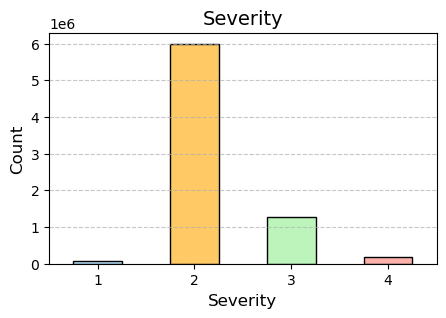

In [27]:
severity_counts = df['Severity'].value_counts().sort_index()
print(severity_counts)

# 绘制柱状图
plt.figure(figsize=(5, 3))
severity_counts.plot(kind='bar', color=colors, edgecolor='black')

# 添加标题和标签
plt.title('Severity', fontsize=14)
plt.xlabel('Severity', fontsize=12)
plt.ylabel('Count', fontsize=12)

# 显示图形
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- 原数据对于交通事故严重性的判定是根据交通事故对于交通的影响程度来判定的，即如果事故造成的延误时间越长则事故严重性越大。可以看到交通事故严重等级为1级，即严重性最轻，造成延误时间最短的的交通事故数量最少。其次是4级，最为严重的交通事故，其对延误造成的时间最长，而2级严重性交通事故是最多的。

In [28]:
# 计算每个严重等级下的平均交通影响距离
severity_impact_distance = df.groupby('Severity')['Distance(mi)'].mean()

# 打印结果
print(severity_impact_distance)

Severity
1    0.113297
2    0.558686
3    0.421730
4    1.497043
Name: Distance(mi), dtype: float64


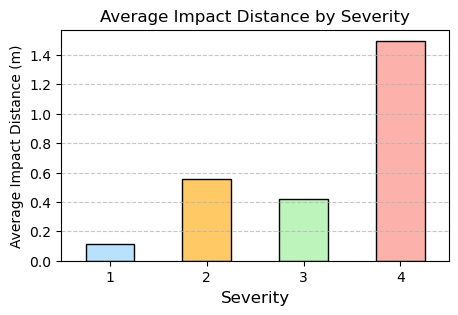

In [29]:
# 绘制柱状图
plt.figure(figsize=(5, 3))
severity_impact_distance.plot(kind='bar', color=colors, edgecolor='black')

# 添加标题和标签
plt.title('Average Impact Distance by Severity', fontsize=12)
plt.xlabel('Severity', fontsize=12)
plt.ylabel('Average Impact Distance (m)', fontsize=10)

# 显示图形
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

这里探究不同等级严重性的交通事故与其对交通影响的道路范围的长度之间的关系，可以看到4级严重性交通事故其造成的交通影响距离最长，1级严重性事故其造成的交通影响距离最短。按常规思考方式，可能默认越严重等级的交通事故其造成的交通影响距离越长，但是这里2级严重性事故其造成的距离影响反而比3级更长。这可能是因为对于交通事故严重性的评判除了对交通造成的距离影响还有其他方面参考因素，例如事故中相关人员的伤亡程度或者对交通情况造成的拥堵时间等。

#### 1.3.2 时间特征
- 首先观察交通事故随着年份的变化。

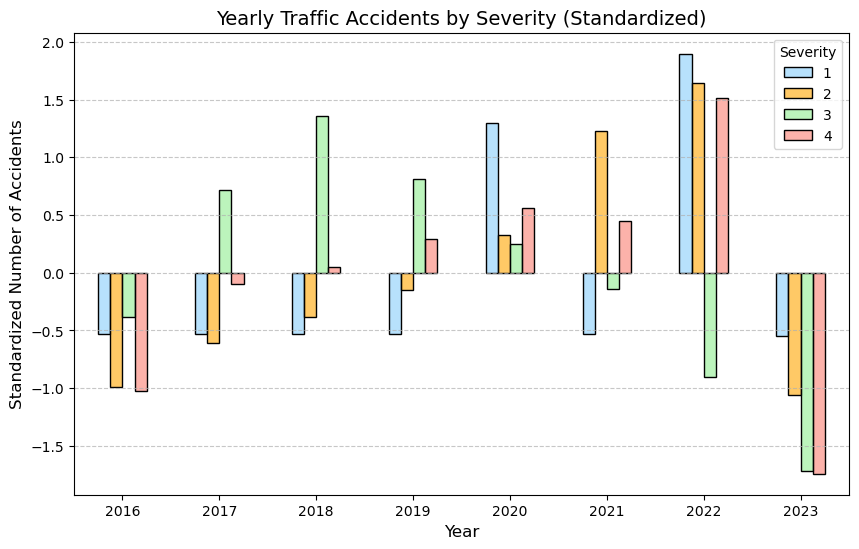

In [30]:
severity_year_counts = df.groupby(['Year', 'Severity']).size().unstack(fill_value=0)

normalized_severity_year_counts = (severity_year_counts - severity_year_counts.mean()) / severity_year_counts.std()

# 使用低饱和度颜色绘制柱状图
ax = normalized_severity_year_counts.plot(
    kind='bar',
    color=colors,
    edgecolor='black',
    figsize=(10, 6)
)

# 设置标题和标签
plt.title('Yearly Traffic Accidents by Severity (Standardized)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Standardized Number of Accidents', fontsize=12)

# 设置图例
plt.legend(title='Severity')

# 设置网格线
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 设置x轴刻度标签旋转角度
plt.xticks(rotation=0)

# 显示图表
plt.show()

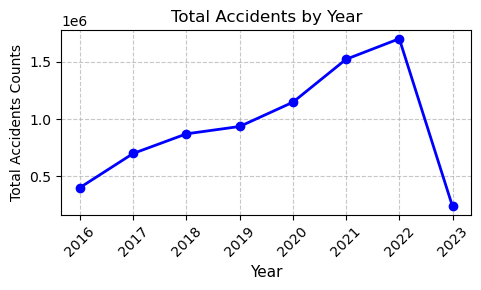

In [31]:
total_accidents_by_year = severity_year_counts.sum(axis=1)

# 绘制折线图
plt.figure(figsize=(5, 3))
plt.plot(total_accidents_by_year.index, total_accidents_by_year, marker='o', linestyle='-', color='blue', linewidth=2)

# 设置标题和标签
plt.title('Total Accidents by Year', fontsize=12)
plt.xlabel('Year', fontsize=11)
plt.ylabel('Total Accidents Counts', fontsize=10)

# 设置网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图表
plt.xticks(rotation=45)  # 可选：旋转x轴标签以提高可读性
plt.tight_layout()       # 自动调整子图参数，使之填充整个图像区域
plt.show()

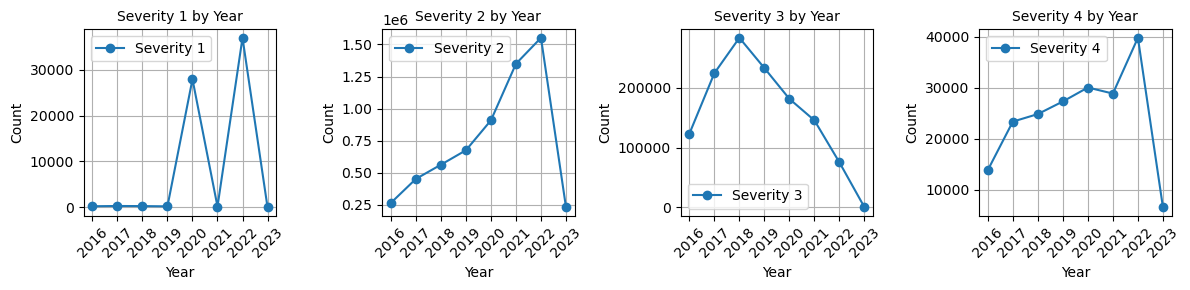

In [32]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))  # 创建一个4行1列的子图布局，总体尺寸

# 循环遍历每个严重等级
for idx, severity in enumerate(severity_year_counts.columns):
    ax = axs[idx]  # 选择一个子图
    ax.plot(severity_year_counts.index, severity_year_counts[severity], marker='o', label=f'Severity {severity}')
    ax.set_title(f'Severity {severity} by Year', fontsize=10)
    ax.set_xlabel('Year', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.legend()
    ax.grid(True)
    ax.set_xticks(severity_year_counts.index)
    ax.set_xticklabels(severity_year_counts.index, rotation=45)  # 设置x轴标签并旋转45度

# 调整子图间距
plt.tight_layout()
plt.show()

由于2023年的交通事故数据只包含到3月份，因此数据并不全面，因此主要只参考2016-2022年的变化。
- 交通事故的总量随着年份增长。
- 其中，可以看到2级严重性交通事故随着年份持续增长，3级交通事故先增长后减少，在2018年达到顶峰，2022年跌入谷底。
- 1级交通事故总体呈现出增长趋势，但是2020年突然大幅增多，这是一种跳跃变化。在2021年又跳跃下降，接着2022年又跳跃上升，这可能是数据源对于交通事故严重性的判定标准发生了变化，或者是因为covid-19对交通事故产生了影响。
- 4级交通事故基本呈现出稳步增长的趋势。
- 在2022年，3级交通事故是最少的，其他三种不同严重性交通事故数量相当。

由于1级交通事故发生的跳跃变化非常不寻常，因此这里画出热力图，更加清晰地观察，到底是在什么时间段，1级交通事故数量发生了翻天覆地的变化。

C:\Users\waitgreen\AppData\Local\Temp\ipykernel_23528\115222479.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_severity1['date'] = df_severity1['Start_Time'].dt.normalize() # 提取日期部分


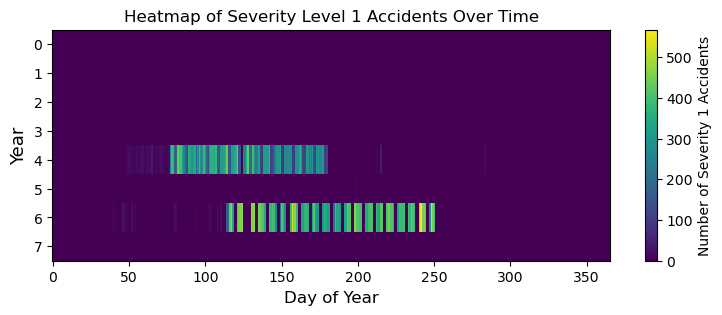

In [33]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df_severity1 = df[df['Severity'] == 1]

# 创建包含日期和Severity1数量的新数据框
df_severity1['date'] = df_severity1['Start_Time'].dt.normalize() # 提取日期部分
df_date = df_severity1.groupby('date').size().reset_index(name='Severity1') # 按日期分组并计数

# 创建包含完整日期范围的数据框
full_date_range = pd.date_range(start=df['Start_Time'].min().normalize(), end=df['Start_Time'].max().normalize())
full_date_df = pd.DataFrame(full_date_range, columns=['date'])

# 合并数据，确保每个日期都有记录
df_date_full = full_date_df.merge(df_date, how='left', on='date')
df_date_full['Severity1'] = df_date_full['Severity1'].fillna(0)
df_date_full.set_index('date', inplace=True)

# 按年份分组，并将数据转换为热力图所需的格式
df_date_full['Year'] = df_date_full.index.year
df_date_full['Day_of_Year'] = df_date_full.index.dayofyear

# 创建透视表
heatmap_data = df_date_full.pivot_table(index='Year', columns='Day_of_Year', values='Severity1', fill_value=0)

# 绘制热力图
plt.figure(figsize=(9, 3))
plt.imshow(heatmap_data, aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar(label='Number of Severity 1 Accidents')
plt.title('Heatmap of Severity Level 1 Accidents Over Time', fontsize=12)
plt.xlabel('Day of Year', fontsize=12)
plt.ylabel('Year', fontsize=13)
plt.show()

可以看到在2020年的3月开始到6月结束以及2022年的4月开始到9月中旬，1级交通事故有明显的发生数量。

接着按月份对交通事故进行分析。

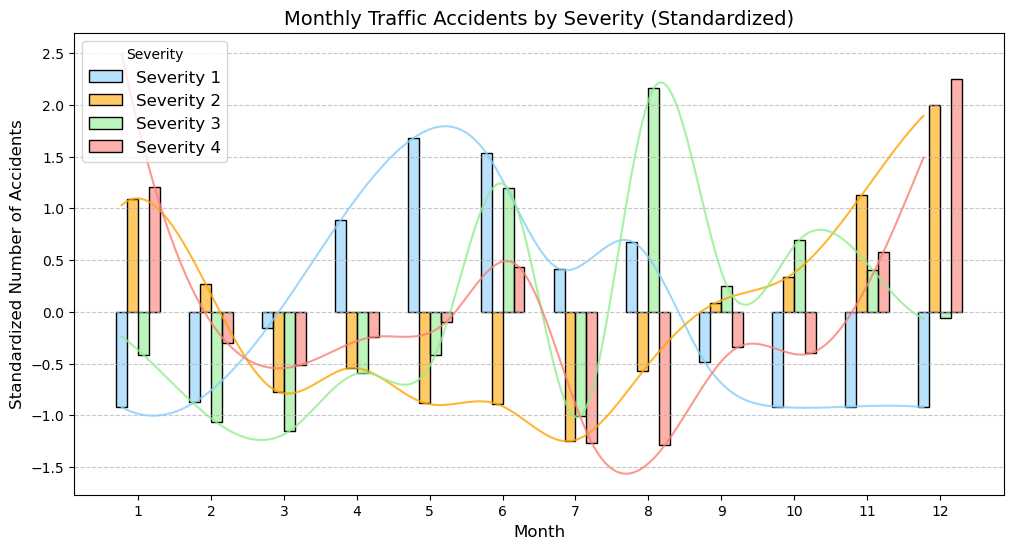

In [34]:
# 按月份和严重等级分组并计数
severity_month_counts = df.groupby(['Month', 'Severity']).size().unstack(fill_value=0)

# 对数据进行 Z-score 标准化
standardized_severity_month_counts = (severity_month_counts - severity_month_counts.mean()) / severity_month_counts.std()

# 绘制柱状图和平滑曲线
fig, ax = plt.subplots(figsize=(12, 6))

# 为了给每个严重等级一个单独的柱子，需要调整柱子的位置
width = 0.15  # 每个柱子的宽度
positions = np.arange(len(standardized_severity_month_counts.index))  # 每个月的基础位置

# 绘制每个严重等级的柱子
for i, severity in enumerate(standardized_severity_month_counts.columns):
    ax.bar(positions + i * width, standardized_severity_month_counts[severity], width=width, label=f'Severity {severity}', color=colors[i], edgecolor='black')

# 绘制平滑曲线
xnew = np.linspace(positions.min(), positions.max(), 300)  # 创建更多的点用于平滑曲线

for i, severity in enumerate(standardized_severity_month_counts.columns):
    spl = make_interp_spline(positions + i * width, standardized_severity_month_counts[severity], k=3)  # 使用3次样条拟合
    y_smooth = spl(xnew)
    ax.plot(xnew, y_smooth, color=colors[i][:3], alpha=0.8)  # 只用RGB，调整透明度

# 添加标题和标签
ax.set_title('Monthly Traffic Accidents by Severity (Standardized)', fontsize=14)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Standardized Number of Accidents', fontsize=12)
ax.set_xticks(positions + width * (len(standardized_severity_month_counts.columns) - 1) / 2)
ax.set_xticklabels(standardized_severity_month_counts.index, rotation=0)
ax.legend(title='Severity', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图形
plt.show()

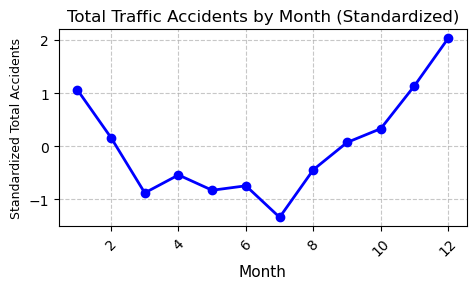

In [35]:
# 计算每个月的所有交通事故数量总和
total_accidents_by_month = severity_month_counts.sum(axis=1)

# 对数据进行 Z-score 标准化
standardized_total_accidents_by_month = (total_accidents_by_month - total_accidents_by_month.mean()) / total_accidents_by_month.std()

# 绘制折线图
plt.figure(figsize=(5, 3))
plt.plot(standardized_total_accidents_by_month.index, standardized_total_accidents_by_month, 
         marker='o', linestyle='-', color='blue', linewidth=2)

# 设置标题和标签
plt.title('Total Traffic Accidents by Month (Standardized)', fontsize=12)
plt.xlabel('Month', fontsize=11)
plt.ylabel('Standardized Total Accidents', fontsize=9)

# 设置网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 设置x轴刻度标签旋转角度
plt.xticks(rotation=45)  # 可选：旋转x轴标签以提高可读性

# 显示图表
plt.tight_layout()       # 自动调整子图参数，使之填充整个图像区域
plt.show()

可以看到不同严重等级交通事故：
- 1级交通事故在4-8月数量较多，对应的季节是春季和夏季。4级交通事故在12月和1月数量最多，推测可能是因为暴雪或者其他冬季极端天气造成的，相反4级交通事故在夏季数量明显减少。2级交通事故和4级交通事故类似，在冬季数量增加明显。3级交通事故在6月和8月最多。
- 根据交通事故总数量随着月份的变化，可以看到在冬季（11月，12月和1月）总体交通事故数量明显大于其他月份，7月为交通事故总数量最少的月份。冬季的极端天气对交通事故的发生可能有一定影响。

继续根据星期几对交通事故分析：

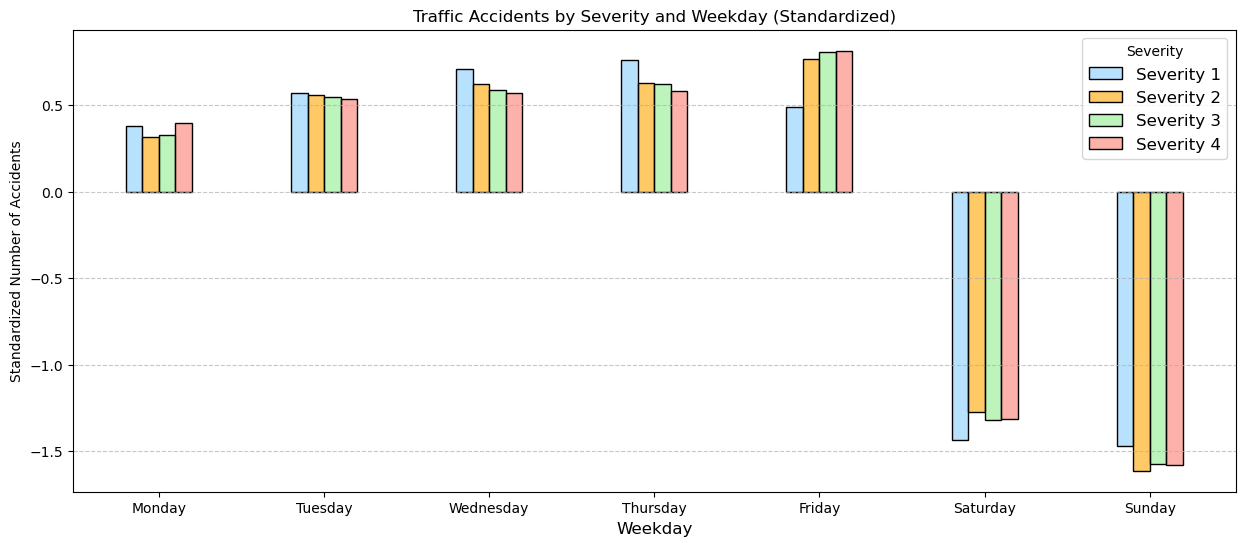

In [36]:
weekday_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['weekday_name'] = df['Weekday'].map(weekday_mapping)

# 按工作日名称和严重等级分组并计数
severity_weekday_counts = df.groupby(['weekday_name', 'Severity']).size().unstack(fill_value=0)

# 确保工作日按正确顺序排列
severity_weekday_counts = severity_weekday_counts.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# 对整个数据集进行 Z-score 标准化
standardized_severity_weekday_counts = (severity_weekday_counts - severity_weekday_counts.mean()) / severity_weekday_counts.std()

# 绘制柱状图
fig, ax = plt.subplots(figsize=(15, 6))

# 为了给每个严重等级一个单独的柱子，需要调整柱子的位置
width = 0.1  # 每个柱子的宽度
positions = np.arange(len(standardized_severity_weekday_counts.index))  # 每个工作日的基础位置

# 绘制每个严重等级的柱子
for i, severity in enumerate(standardized_severity_weekday_counts.columns):
    ax.bar(positions + i * width, standardized_severity_weekday_counts[severity], width=width, label=f'Severity {severity}', color=colors[i], edgecolor='black')

# 添加标题和标签
ax.set_title('Traffic Accidents by Severity and Weekday (Standardized)', fontsize=12)
ax.set_xlabel('Weekday', fontsize=12)
ax.set_ylabel('Standardized Number of Accidents', fontsize=10)
ax.set_xticks(positions + width * (len(standardized_severity_weekday_counts.columns) - 1) / 2)
ax.set_xticklabels(standardized_severity_weekday_counts.index, rotation=0)
ax.legend(title='Severity', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图形
plt.show()

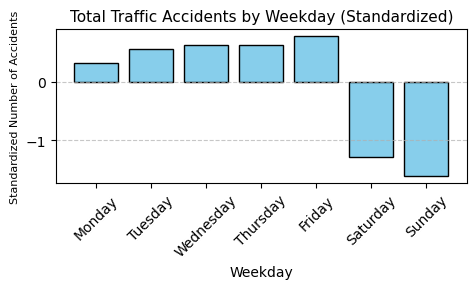

In [37]:
# 按工作日名称分组并计算每个工作日的总交通事故数量
total_weekday_counts = df.groupby('weekday_name').size()

# 对数据进行 Z-score 标准化
standardized_total_weekday_counts = (total_weekday_counts - total_weekday_counts.mean()) / total_weekday_counts.std()

# 确保工作日按正确顺序排列
ordered_weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
standardized_total_weekday_counts = standardized_total_weekday_counts.reindex(ordered_weekdays)

# 绘制柱状图
plt.figure(figsize=(5, 3))
plt.bar(standardized_total_weekday_counts.index, standardized_total_weekday_counts, color='skyblue', edgecolor='black')

# 添加标题和标签
plt.title('Total Traffic Accidents by Weekday (Standardized)', fontsize=11)
plt.xlabel('Weekday', fontsize=10)
plt.ylabel('Standardized Number of Accidents', fontsize=8)

# 添加网格线
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 设置 x 轴标签旋转角度以提高可读性
plt.xticks(rotation=45)

# 自动调整子图参数，以便填充整个图像区域
plt.tight_layout()

# 显示图表
plt.show()

可以看到不同严重等级交通事故：
- 在工作日，周一到周五，交通事故总数量逐渐增长，周末交通事故非常少，尤其是星期日。由此可以看出，人们通勤上班工作对交通事故的发生影响很大。而在周末，人们一般在家休息，并不开车出行，因此交通事故的数量大大减少。根据星期几划分，不同严重等级交通事故数量差距不大，基本都比较相当。

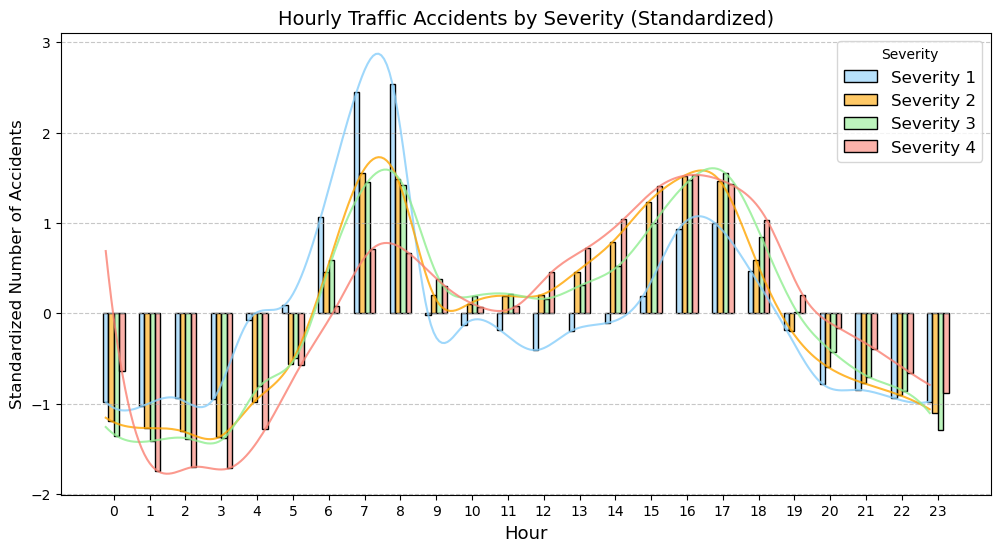

In [38]:
# 按小时和严重等级分组并计数
severity_hour_counts = df.groupby(['Hour', 'Severity']).size().unstack(fill_value=0)

# 对数据进行 Z-score 归一化
standardized_severity_hour_counts = (severity_hour_counts - severity_hour_counts.mean()) / severity_hour_counts.std()

# 绘制柱状图和平滑曲线
fig, ax = plt.subplots(figsize=(12, 6))

# 为了给每个严重等级一个单独的柱子，需要调整柱子的位置
width = 0.15  # 每个柱子的宽度
positions = np.arange(len(standardized_severity_hour_counts.index))  # 每个小时的基础位置

# 绘制每个严重等级的柱子
for i, severity in enumerate(standardized_severity_hour_counts.columns):
    ax.bar(positions + i * width, standardized_severity_hour_counts[severity], width=width, label=f'Severity {severity}', color=colors[i], edgecolor='black')

# 绘制平滑曲线
xnew = np.linspace(positions.min(), positions.max(), 300)  # 创建更多的点用于平滑曲线

for i, severity in enumerate(standardized_severity_hour_counts.columns):
    spl = make_interp_spline(positions + i * width, standardized_severity_hour_counts[severity], k=3)  # 使用3次样条拟合
    y_smooth = spl(xnew)
    ax.plot(xnew, y_smooth, color=colors[i][:3], alpha=0.8)  # 只用RGB，调整透明度

# 添加标题和标签
ax.set_title('Hourly Traffic Accidents by Severity (Standardized)', fontsize=14)
ax.set_xlabel('Hour', fontsize=13)
ax.set_ylabel('Standardized Number of Accidents', fontsize=12)
ax.set_xticks(positions + width * (len(standardized_severity_hour_counts.columns) - 1) / 2)
ax.set_xticklabels(standardized_severity_hour_counts.index, rotation=0)
ax.legend(title='Severity', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图形
plt.show()

可以看到不同严重等级交通事故：

- 不同严重等级交通事故都呈现出了一种周期性的变化，类似sin或者cos函数，并且基本所有严重等级交通事故都在6点到9点和15-18点具有两个双高峰。这两个高峰对应的时间点同时也是上下班高峰，进一步说明了人们通勤上班使用车辆或者交通工具会增加交通事故的发生。

接着对交通事故发生时处于一天当中的第几分钟进行分析，由于如果对分钟进行独热编码，将会产生大量的虚拟变量，因此这里先将分钟该变量进行频率编码：

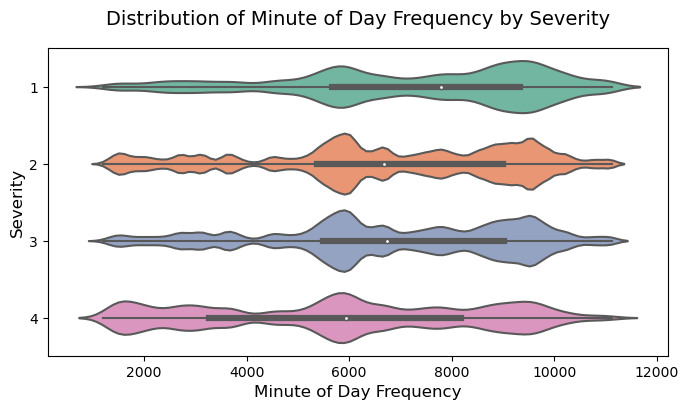

In [39]:
# 计算每个分钟值的频率
minute_frequencies = df['Minute_of_Day'].value_counts()

# 创建频率编码映射字典
minute_to_frequency = minute_frequencies.to_dict()

# 应用频率编码
df['Minute_of_Day_Frequency'] = df['Minute_of_Day'].map(minute_to_frequency)

# 将Severity列转换为类别型数据
df['Severity'] = df['Severity'].astype('category')

# 创建小提琴图来可视化不同严重程度下的分钟频率分布
plt.figure(figsize=(8, 4))
sns.violinplot(y='Severity', x='Minute_of_Day_Frequency', data=df, palette="Set2")

# 设置图的标签和标题
plt.ylabel('Severity', size=12, labelpad=3)
plt.xlabel('Minute of Day Frequency', size=12, labelpad=3)
plt.title('Distribution of Minute of Day Frequency by Severity', size=14, y=1.05)

# 显示图形
plt.show()

根据这个不同等级严重性交通事故和每分钟发生的交通事故数量的小提琴图，可以看到，1级，2级，3级严重性交通事故基本都具有双峰，表明有许多分钟每分钟发生事故6000次和9000次。这种双峰现象可能反映了某些时间段可能事故的发生频率非常高（如交通高峰期），而其他时间段则相对较低。而关于4级严重性交通事故可以看到除了有许多分钟每分钟发生事故6000次和9000次，但还有许多分钟每分钟只发生事故1000次。这说明，4级事故的分布范围更广，其发生的频率不仅集中在高频率的时间段，也集中在较低频率的时间段。这可能表示4级事故在不同情况下的发生频率差异较大，可能与事故的性质或造成的条件更复杂有关。

接着对不同类型的白天夜晚计时方法分析：

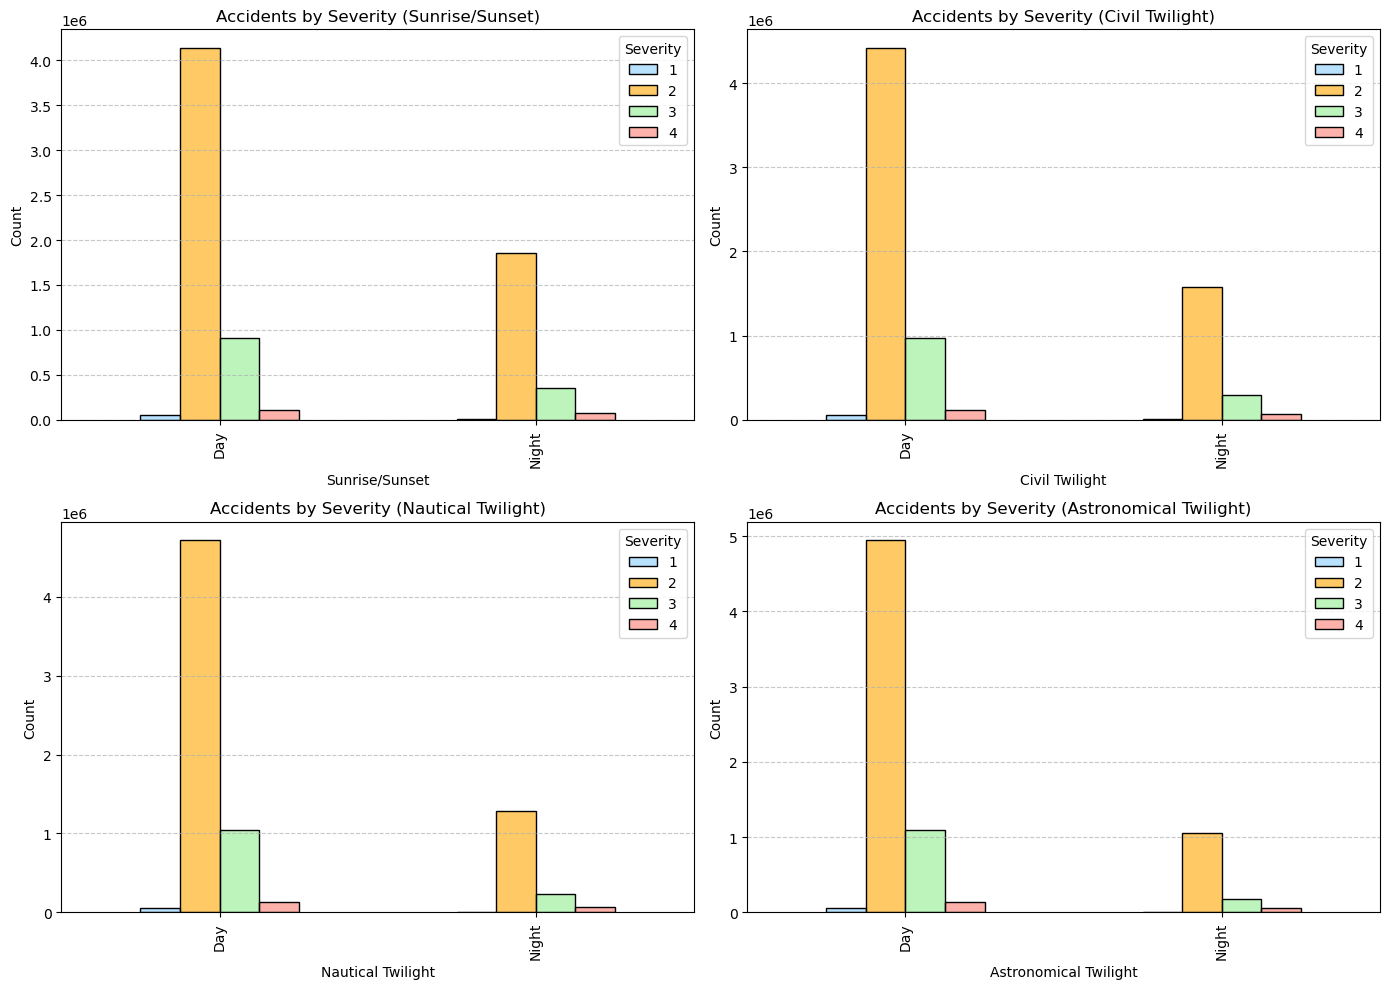

In [40]:
severity_time_counts = df.groupby(['Sunrise_Sunset', 'Severity']).size().unstack(fill_value=0)
severity_civil_counts = df.groupby(['Civil_Twilight', 'Severity']).size().unstack(fill_value=0)
severity_nautical_counts = df.groupby(['Nautical_Twilight', 'Severity']).size().unstack(fill_value=0)
severity_astronomical_counts = df.groupby(['Astronomical_Twilight', 'Severity']).size().unstack(fill_value=0)

# 可视化分析
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sunrise_Sunset 分布
severity_time_counts.plot(kind='bar', ax=axes[0, 0], color=colors, edgecolor='black')
axes[0, 0].set_title('Accidents by Severity (Sunrise/Sunset)')
axes[0, 0].set_xlabel('Sunrise/Sunset')
axes[0, 0].set_ylabel('Count')
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Civil_Twilight 分布
severity_civil_counts.plot(kind='bar', ax=axes[0, 1], color=colors, edgecolor='black')
axes[0, 1].set_title('Accidents by Severity (Civil Twilight)')
axes[0, 1].set_xlabel('Civil Twilight')
axes[0, 1].set_ylabel('Count')
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Nautical_Twilight 分布
severity_nautical_counts.plot(kind='bar', ax=axes[1, 0], color=colors, edgecolor='black')
axes[1, 0].set_title('Accidents by Severity (Nautical Twilight)')
axes[1, 0].set_xlabel('Nautical Twilight')
axes[1, 0].set_ylabel('Count')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Astronomical_Twilight 分布
severity_astronomical_counts.plot(kind='bar', ax=axes[1, 1], color=colors, edgecolor='black')
axes[1, 1].set_title('Accidents by Severity (Astronomical Twilight)')
axes[1, 1].set_xlabel('Astronomical Twilight')
axes[1, 1].set_ylabel('Count')
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

可以直观地看到不管哪种白天夜晚计时方法，夜晚的交通事故数量与白天相比大大锐减，并且1级交通事故在夜晚的发生概率几乎为0。白天发生事故的总数量基本为夜晚的4倍左右。

#### 1.3.3 空间特征

首先对时区进行分析：

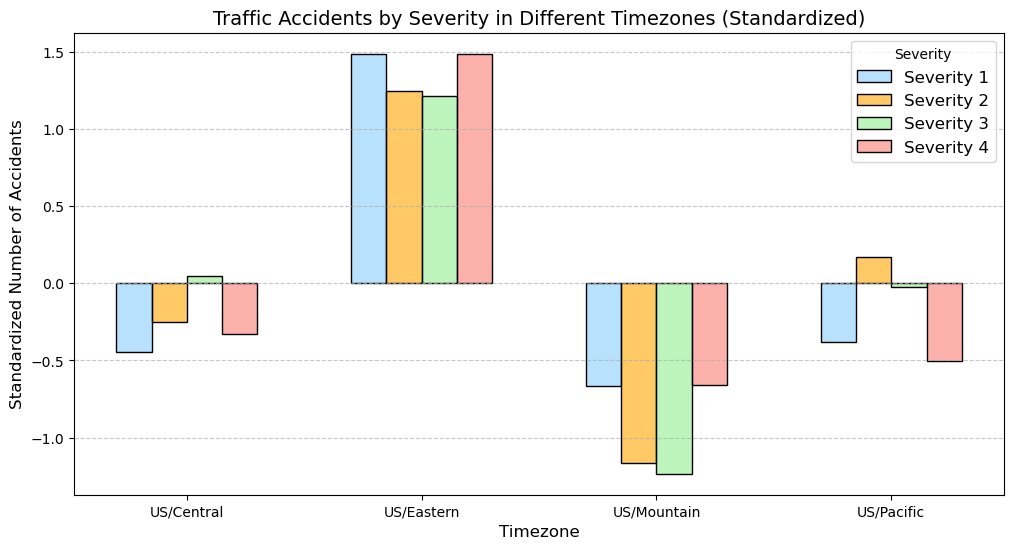

In [41]:
severity_timezone_counts = df.groupby(['Timezone', 'Severity']).size().unstack(fill_value=0)

# 对数据进行 Z-score 标准化
standardized_severity_timezone_counts = (severity_timezone_counts - severity_timezone_counts.mean()) / severity_timezone_counts.std()

# 绘制柱状图
fig, ax = plt.subplots(figsize=(12, 6))

# 设置柱子的宽度和位置
width = 0.15  # 每个柱子的宽度
positions = np.arange(len(standardized_severity_timezone_counts.index))  # 每个时区的基础位置

# 绘制每个严重等级的柱子
for i, severity in enumerate(standardized_severity_timezone_counts.columns):
    ax.bar(positions + i * width, standardized_severity_timezone_counts[severity], width=width, label=f'Severity {severity}', color=colors[i], edgecolor='black')

# 添加标题和标签
ax.set_title('Traffic Accidents by Severity in Different Timezones (Standardized)', fontsize=14)
ax.set_xlabel('Timezone', fontsize=12)
ax.set_ylabel('Standardized Number of Accidents', fontsize=12)
ax.set_xticks(positions + width * (len(standardized_severity_timezone_counts.columns) - 1) / 2)
ax.set_xticklabels(standardized_severity_timezone_counts.index, rotation=0)
ax.legend(title='Severity', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图形
plt.show()

可以直接看到美国东时区是发生交通事故最多的地方，接着是Pacific区域，而山区是发生事故最少的地方。

接着按州进行分析：

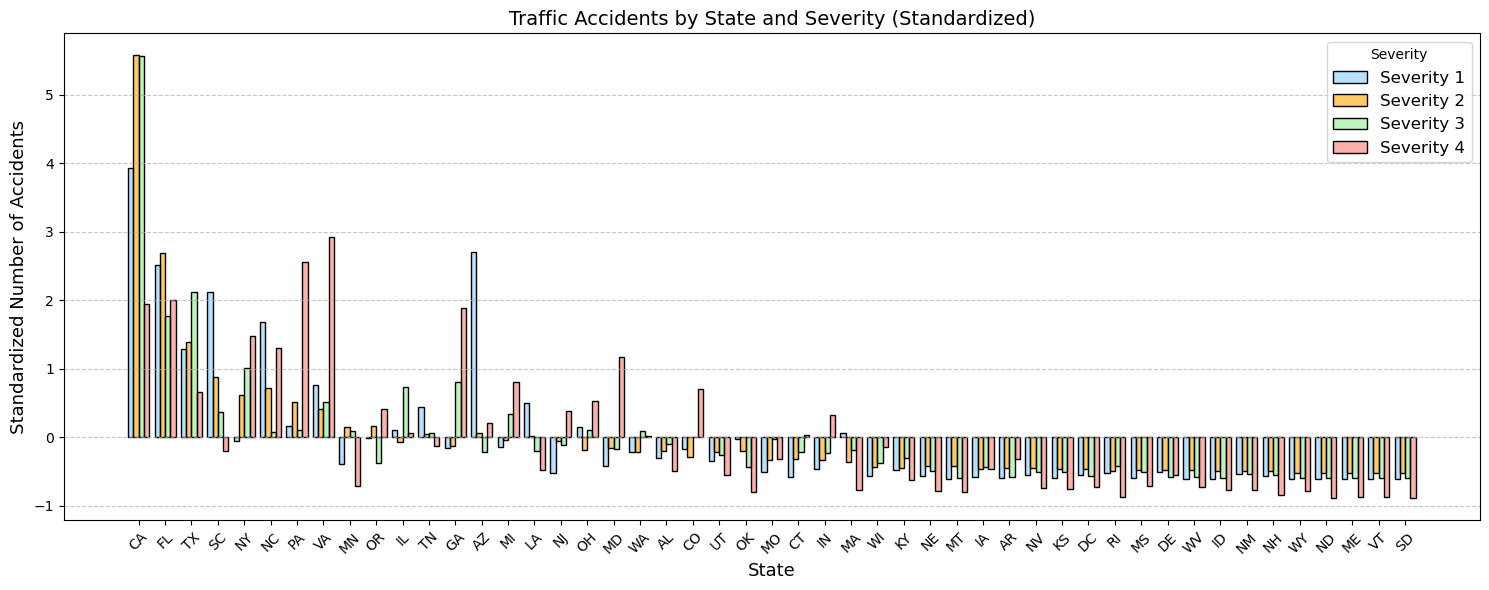

In [42]:
# 按州和严重等级分组并计数
severity_state_counts = df.groupby(['State', 'Severity']).size().unstack(fill_value=0)

# 计算每个州的总事故量
severity_state_counts['Total'] = severity_state_counts.sum(axis=1)

# 对事故数量进行 Z-score 标准化
standardized_severity_state_counts = (severity_state_counts - severity_state_counts.mean()) / severity_state_counts.std()

# 根据每个州的总事故量排序
standardized_severity_state_counts = standardized_severity_state_counts.sort_values(by='Total', ascending=False)

# 绘制柱状图
fig, ax = plt.subplots(figsize=(15, 6))

# 设置柱子的宽度和位置
width = 0.2  # 每个柱子的宽度
positions = np.arange(len(standardized_severity_state_counts.index))  # 每个州的基础位置

# 绘制每个严重等级的柱子
for i, severity in enumerate(standardized_severity_state_counts.columns[:-1]):  # 不绘制 'Total' 列
    ax.bar(positions + i * width, standardized_severity_state_counts[severity], width=width, 
           label=f'Severity {severity}', color=colors[i], edgecolor='black')

# 添加标题和标签
ax.set_title('Traffic Accidents by State and Severity (Standardized)', fontsize=14)
ax.set_xlabel('State', fontsize=13)
ax.set_ylabel('Standardized Number of Accidents', fontsize=13)
ax.set_xticks(positions + width * (len(standardized_severity_state_counts.columns) - 2) / 2)
ax.set_xticklabels(standardized_severity_state_counts.index, rotation=45)
ax.legend(title='Severity', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()  # 调整布局以防止标签被遮挡
plt.show()

可以看到总交通事故数量排名前三的是CA，FL，TX这三个州，但如果根据4级严重性事故数量排名，可以看到排名最高的三个州是VA，PA，FL。

接着按街道分析：
- 由于街道包含的类型太多，因此首先要进行一些筛选，这里首先统计街道变量中出现频率最高的50个单词。

In [43]:
# 提取街道名称，去掉空值和重复项
street_names = df['Street'].dropna().unique().tolist()

# 清理街道名称，不进行小写转换
cleaned_streets = [re.sub(r'[^\w\s]', ' ', name) for name in street_names]

# 分词
words = [word for name in cleaned_streets for word in name.split()]

# 统计词频
word_counts = Counter(words)

# 获取出现频率最高的50个单词
most_common_50 = word_counts.most_common(50)

# 输出结果
print('The 50 most common words:')
print(', '.join(f"{word}: {count}" for word, count in most_common_50))

The 50 most common words:
Rd: 85480, Dr: 48518, St: 39718, Ave: 36400, Ln: 20225, N: 19179, S: 19097, E: 17636, W: 17342, Blvd: 12819, Ct: 9439, Way: 9332, Highway: 7807, Pl: 6170, SW: 5501, Cir: 5463, Hwy: 5066, NE: 4935, NW: 4861, State: 4591, Road: 4562, Pkwy: 4486, SE: 4454, Old: 4184, Creek: 3734, US: 3346, Hill: 3147, Park: 3057, Lake: 2914, County: 2821, Trl: 2761, Route: 2716, Ter: 2066, Valley: 1975, Ridge: 1968, Mill: 1646, Oak: 1423, River: 1393, Loop: 1331, Avenue: 1213, Church: 1199, Mountain: 1164, Springs: 1090, Canyon: 1090, Farm: 1083, I: 1078, Run: 1076, Pike: 1028, Bridge: 996, Point: 981


接着选择常见的并且是道路类型的街道名称，并将其组合成一个新的列表：

In [44]:
st_type = ['Rd', 'Dr', 'St', 'Ave', 'Ln', 'Blvd', 'Ct', 'Way', 'Highway', 'Pl', 'Cir', 'Hwy', 'State', 'Road', 'Pkwy', 'Hill', 'Park', 'Lake',
          'Creek', 'Trl', 'Route', 'US', 'Ter', 'Valley', 'Ridge', 'River', 'Loop', 'Avenue', 'Mountain', 'Canyon', 'County', 
          'Springs', 'Farm', 'Run', 'Pike', 'Bridge', 'I']
print(*st_type, sep = ", ")  

Rd, Dr, St, Ave, Ln, Blvd, Ct, Way, Highway, Pl, Cir, Hwy, State, Road, Pkwy, Hill, Park, Lake, Creek, Trl, Route, US, Ter, Valley, Ridge, River, Loop, Avenue, Mountain, Canyon, County, Springs, Farm, Run, Pike, Bridge, I


接着看不同道路类型不同等级严重性交通事故的分布：

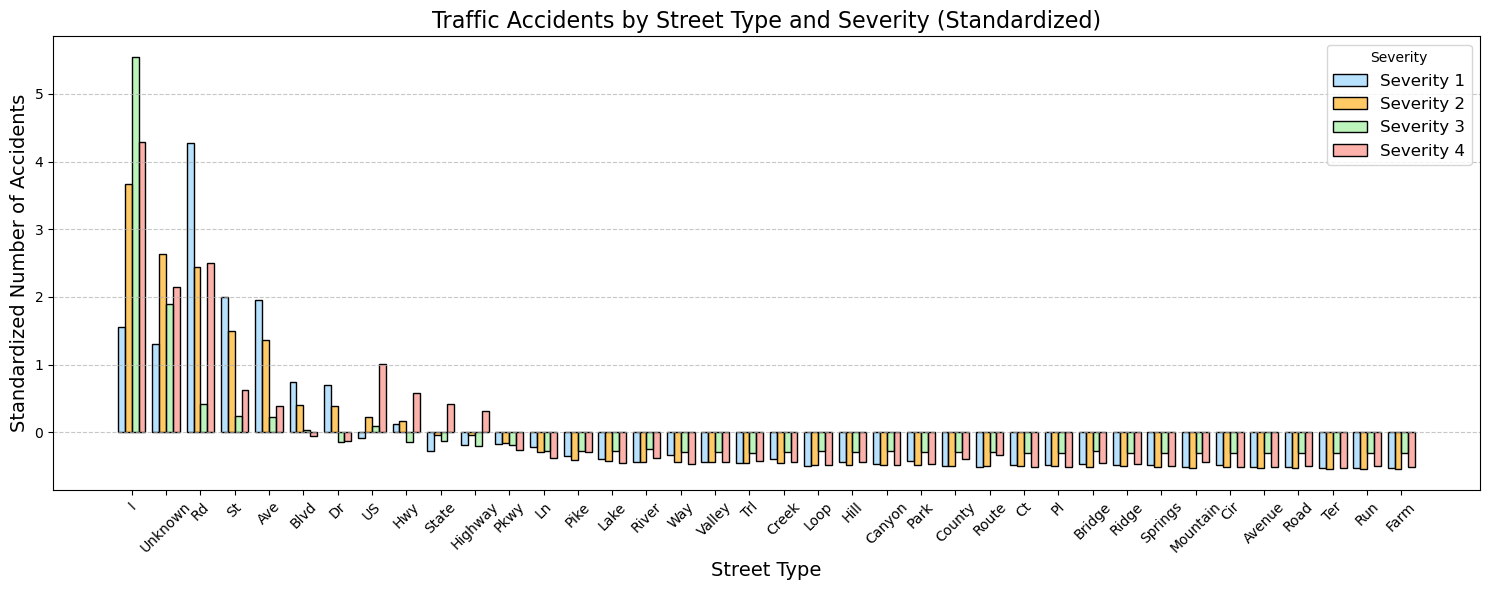

In [45]:
pattern = r'\b(' + '|'.join(st_type) + r')\b'

# 从 'Street' 列中提取街道类型，创建一个新列 'Street_Type'
df['Street_Type'] = df['Street'].apply(lambda x: re.search(pattern, x).group(1) if re.search(pattern, x) else 'Unknown')

# 按街道类型和严重等级分组并计数
severity_street_counts = df.groupby(['Street_Type', 'Severity']).size().unstack(fill_value=0)

# 计算每种街道类型的总事故量
severity_street_counts['Total'] = severity_street_counts.sum(axis=1)

# 对事故数量进行 Z-score 标准化
standardized_severity_street_counts = (severity_street_counts - severity_street_counts.mean()) / severity_street_counts.std()

# 根据每种街道类型的总事故量排序
standardized_severity_street_counts = standardized_severity_street_counts.sort_values(by='Total', ascending=False)

# 绘制柱状图
fig, ax = plt.subplots(figsize=(15, 6))

# 设置柱子的宽度和位置
width = 0.2  # 每个柱子的宽度
positions = np.arange(len(standardized_severity_street_counts.index))  # 每个街道类型的基础位置

# 绘制每个严重等级的柱子
for i, severity in enumerate(standardized_severity_street_counts.columns[:-1]):  # 不绘制 'Total' 列
    ax.bar(positions + i * width, standardized_severity_street_counts[severity], width=width, 
           label=f'Severity {severity}', color=colors[i], edgecolor='black')

# 添加标题和标签
ax.set_title('Traffic Accidents by Street Type and Severity (Standardized)', fontsize=16)
ax.set_xlabel('Street Type', fontsize=14)
ax.set_ylabel('Standardized Number of Accidents', fontsize=14)
ax.set_xticks(positions + width * (len(standardized_severity_street_counts.columns) - 2) / 2)
ax.set_xticklabels(standardized_severity_street_counts.index, rotation=45)
ax.legend(title='Severity', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()  # 调整布局以防止标签被遮挡
plt.show()

可以看到：根据之前提取得到的高频出现的街道类型，在'I'，'Rd'，'St'，'Ave'这四种类型的道路上，交通事故发生的总数量最多。但是如果根据4级严重性交通事故数量排序，首先可以看到'I'州际公路断层第一，其数量远远超过其他道路类型，然后是'Rd'和'US'美国国道，接着是'St'或者'Hwy'，这两种道路类型事故数量不相上下。但是也可以认为'Hwy'和'Highway'是同一种道路类型，如果这样考虑，那4级严重性交通事故数量排名前四的是：'I'，'Rd'，'US'和高速公路。这显示出不同道路类型的限制速度也会影响交通事故的发生。较高的速度限制与撞车和死亡的可能性增加有关。

此外，'I'州际公路上发生的3级交通事故也异常得多，其不同严重性交通事故总量远超其他道路，但是再结合之前街道名称中该道路类型的出现频率，'I'的出现频率并不是很高，这是非常诡异的。这有可能说明了'I'这类道路类型其交通流量很大，事故发生的数量也越多。也有可能是因为'I'这类道路类型有非常多的重复名称，但是'Rd'类型其不同的名称包含许多，毕竟常规道路的名称是非常丰富的，但是州际公路只有几个固定的编号。此外还有可能是因为在对原始街道名称进行分类时，如果道路名称为'I-98 Rd'，根据匹配规则，会将其匹配给第一个识别到的街道类型'I'，而不是'Rd'，因此这也可能造成一些数据误差。但是总体来看，'I'州际公路是一个非常容易发生交通事故的道路类型。

因此如果需要提取出道路类型作为一个空间特征，可以根据这个结果选择'I','Rd'，'St'，'Ave'，'US'，'Highway'这六种比较特别的道路类型。

除此之外，还有一些表示地点的object变量，如果直接使用独热编码则会产生太多的虚拟变量，因此这里也对它们采用频率编码：

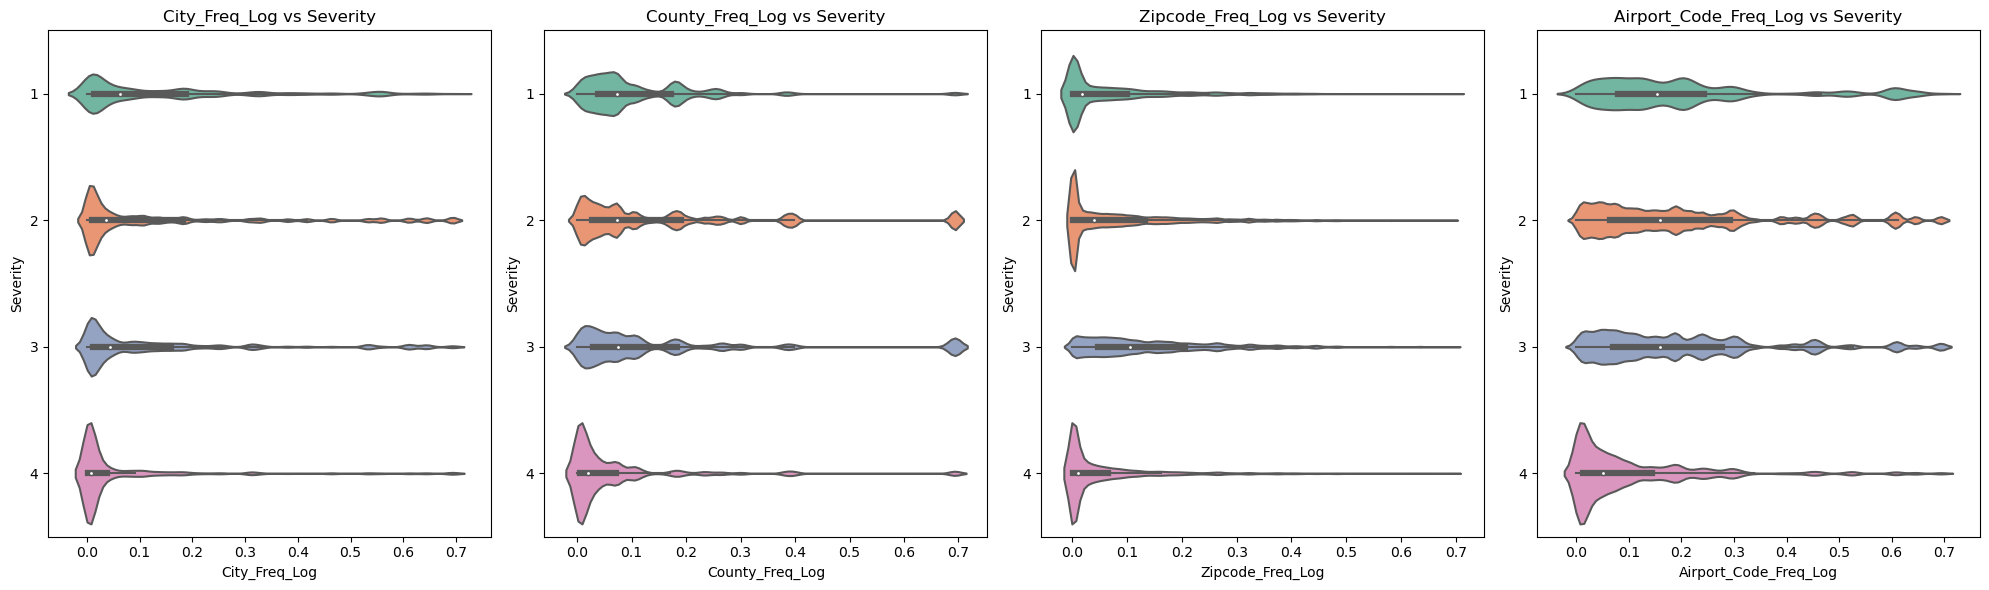

In [46]:
# 对频率编码后的列进行 Min-Max 归一化和对数变换
scaler = MinMaxScaler()

columns_to_encode = ['City', 'County', 'Zipcode', 'Airport_Code']

for col in columns_to_encode:
    # 计算每个类别的频率
    frequency_map = df[col].value_counts().to_dict()
    
    # 应用频率编码
    df[col + '_Freq'] = df[col].map(frequency_map)

# 需要绘制的频率编码列
columns_to_plot = ['City_Freq', 'County_Freq', 'Zipcode_Freq', 'Airport_Code_Freq']

# Min-Max 归一化和对数变换
for col in columns_to_plot:
    # Min-Max 归一化
    df[col + '_MinMax'] = scaler.fit_transform(df[[col]])
    
    # 对数变换，防止 log(0) 错误，通常加 1
    df[col + '_Log'] = np.log1p(df[col + '_MinMax'])

# 设置画布大小
plt.figure(figsize=(20, 6))

# 使用子图（subplots），一行四列
for i, col in enumerate([col + '_Log' for col in columns_to_plot], 1):
    plt.subplot(1, 4, i)  # 创建 1x4 网格，选择第 i 个图
    sns.violinplot(x=col, y='Severity', data=df, palette="Set2")
    plt.title(f'{col} vs Severity')  # 设置标题
    plt.xlabel(col)  # 设置X轴标签
    plt.ylabel('Severity')  # 设置Y轴标签

# 调整图形布局
plt.tight_layout()
plt.show()

可以看到，关于4级严重性交通事故，其相比于1级，2级，3级，发生在的地点中许多城市，县和气象站台都出现的频率很低。推测这可能是因为4级事故更加倾向于发生在较偏远或不太常见的地点。可能这些地点交通流量较少，但一旦发生事故，情况可能更严重。此外这些地点可能有较差的道路条件、急弯、较复杂的交通环境或较长的反应时间，这些因素可能会导致事故的严重性上升。并且，由于4级交通事故更容易发生在频率较低的地点，这些地点可能和较少的急救设施或更长的救援时间等外部因素相关，所以导致事故更加严重。

接着根据原数据中提取得到的POI信息分析。

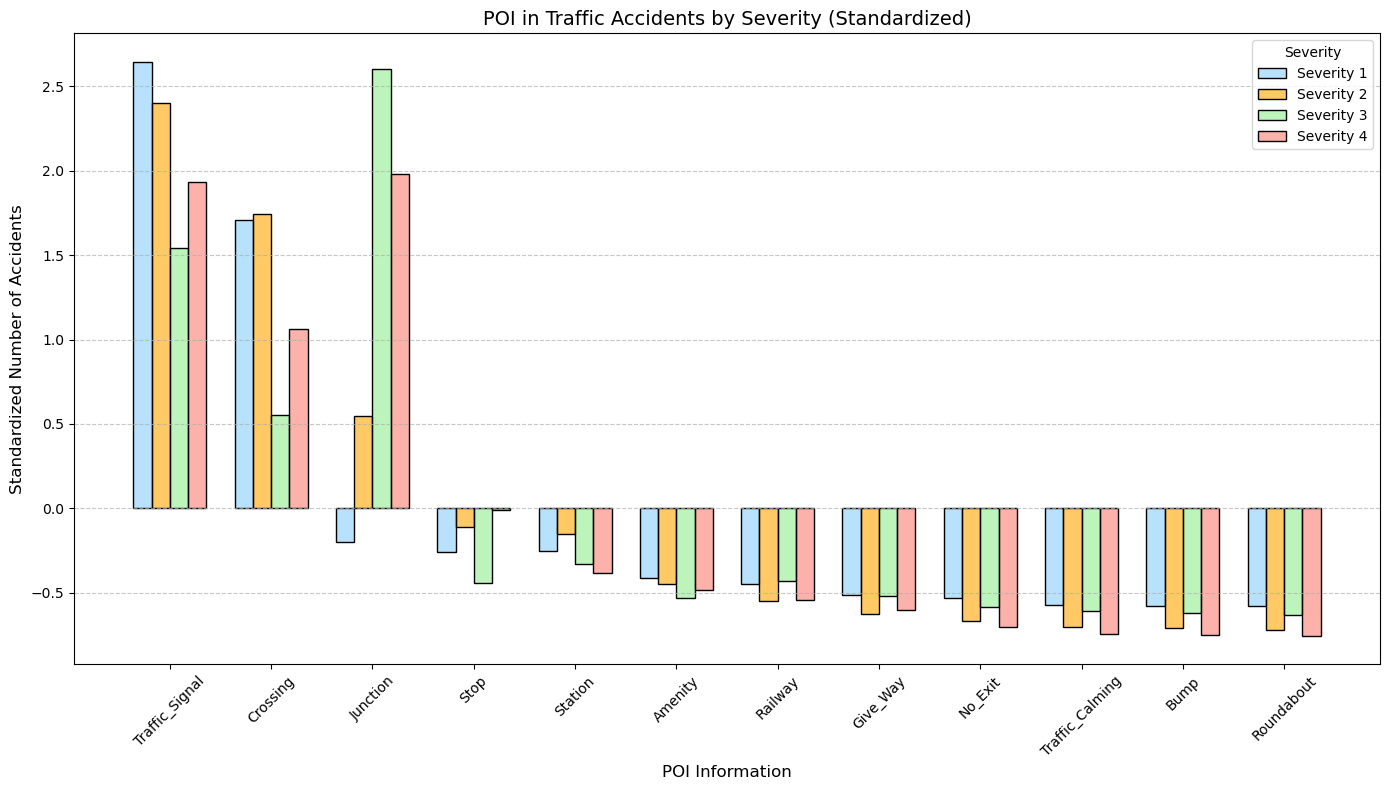

In [47]:
space_features = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 
                  'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

# 计算每个严重等级下的交通事故总数
severity_counts = df['Severity'].value_counts().sort_index()

# 计算每个严重等级下每个特征为 True 的计数
severity_space_true_counts = df.groupby('Severity')[space_features].sum()

# 计算每个严重等级下每个特征的百分比
severity_space_true_percentage = (severity_space_true_counts.T / severity_counts).T * 100

# 转置数据框，以便处理
severity_space_counts_transposed = severity_space_true_percentage.T

# Z-score 标准化
scaler = StandardScaler()
severity_space_counts_standardized = pd.DataFrame(
    scaler.fit_transform(severity_space_counts_transposed),
    columns=severity_space_counts_transposed.columns,
    index=severity_space_counts_transposed.index
)

# 计算每个特征的总数量（所有严重等级下的总和）
total_true_counts = severity_space_true_counts.sum()

# 根据总数量排序
sorted_features = total_true_counts.sort_values(ascending=False).index

# 按照排序后的顺序重新排列数据
sorted_severity_space_counts_standardized = severity_space_counts_standardized.loc[sorted_features]

# 设置柱子宽度
width = 0.18
positions = np.arange(len(sorted_features))

# 绘制柱状图
fig, ax = plt.subplots(figsize=(14, 8))

for i, severity in enumerate(sorted_severity_space_counts_standardized.columns):
    ax.bar(positions + i * width, sorted_severity_space_counts_standardized[severity], width=width, 
           label=f'Severity {severity}', color=colors[i % len(colors)], edgecolor='black')

# 添加标题和标签
ax.set_title('POI in Traffic Accidents by Severity (Standardized)', fontsize=14)
ax.set_xlabel('POI Information', fontsize=12)
ax.set_ylabel('Standardized Number of Accidents', fontsize=12)
ax.set_xticks(positions + width * (len(sorted_severity_space_counts_standardized.columns) - 1) / 2)
ax.set_xticklabels(sorted_features, rotation=45)
ax.legend(title='Severity')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()  # 调整布局以防止标签被遮挡
plt.show()

可以看到，在有交通信号灯和十字交叉路口以及交汇处的地方是事故频发路段，其中在有交通信号灯的地方，交通事故总数量最多，而4级严重性交通事故在交汇处发生的最多。这说明当车流量较大，且交通情况比较复杂，存在车辆与车辆相遇或者车辆和行人相遇的情况时，交通事故更易发生。此外可以看到，当事故发生周围有减速带或者驼峰，则事故发生的数量较少，这可以证明这种交通设施对于交通事故的预防是有帮助的，车速的降低会避免交通事故的发生。Traffic_Calming装置的存在伴随着较低的交通事故发生率也证明了这一点。

#### 1.3.4 天气特征

首先分析天气特征对交通事故的影响：

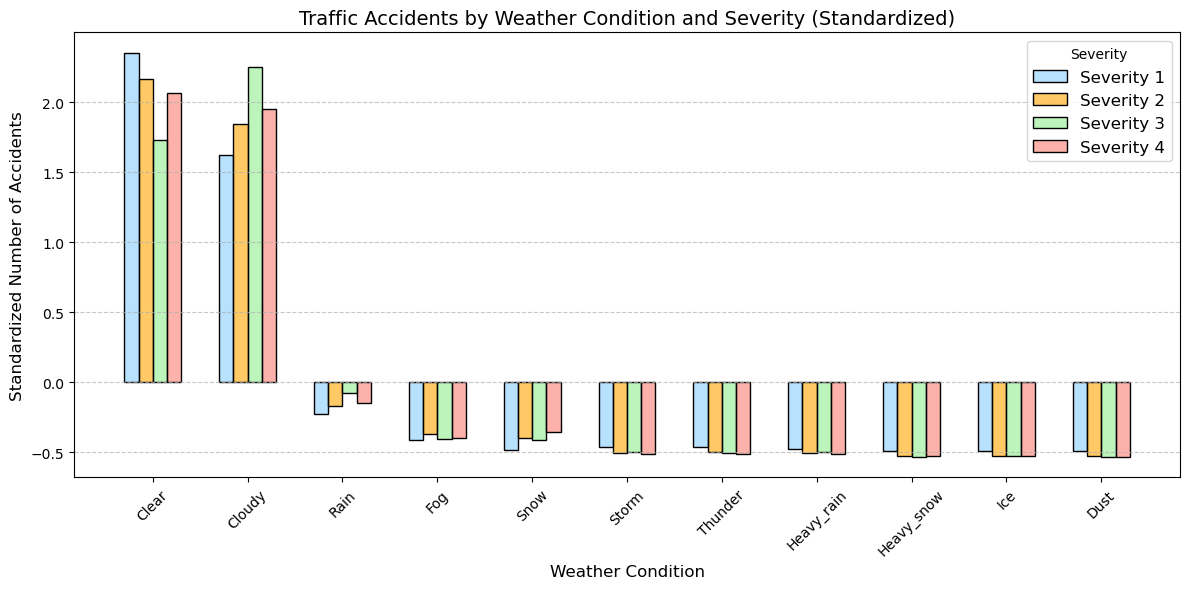

In [48]:
# 按天气条件和严重等级分组并计数
severity_weather_counts = df.groupby(['Weather_Condition_Simplified', 'Severity']).size().unstack(fill_value=0)

# 计算每种天气条件下的总事故量
severity_weather_counts['Total'] = severity_weather_counts.sum(axis=1)

# 对事故数量进行 Z-score 标准化
standardized_severity_weather_counts = (severity_weather_counts - severity_weather_counts.mean()) / severity_weather_counts.std()

# 根据每种天气条件的总事故量进行排序
standardized_severity_weather_counts = standardized_severity_weather_counts.sort_values(by='Total', ascending=False)

# 绘制柱状图
fig, ax = plt.subplots(figsize=(12, 6))

# 设置柱子的宽度和位置
width = 0.15  # 每个柱子的宽度
positions = np.arange(len(standardized_severity_weather_counts.index))  # 每种天气条件的基础位置

# 绘制每个严重等级的柱子
for i, severity in enumerate(standardized_severity_weather_counts.columns[:-1]):  # 不绘制 'Total' 列
    ax.bar(positions + i * width, standardized_severity_weather_counts[severity], width=width, 
           label=f'Severity {severity}', color=colors[i], edgecolor='black')

# 添加标题和标签
ax.set_title('Traffic Accidents by Weather Condition and Severity (Standardized)', fontsize=14)
ax.set_xlabel('Weather Condition', fontsize=12)
ax.set_ylabel('Standardized Number of Accidents', fontsize=12)
ax.set_xticks(positions + width * (len(standardized_severity_weather_counts.columns) - 2) / 2)
ax.set_xticklabels(standardized_severity_weather_counts.index, rotation=45)
ax.legend(title='Severity', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()  # 调整布局以防止标签被遮挡
plt.show()

可以看到在'Clear'和'Cloudy'的天气情况下，发生的交通事故的总数量最多，其次是'Rain'，'Fog'，'Snow'雨天雾天雪天这三种天气情况。在这三者之中，关于4级严重性交通事故，雨天发生的数量最多，其次是雪天，然后是雾天。

继续分析不同风向不同等级交通事故的分布：

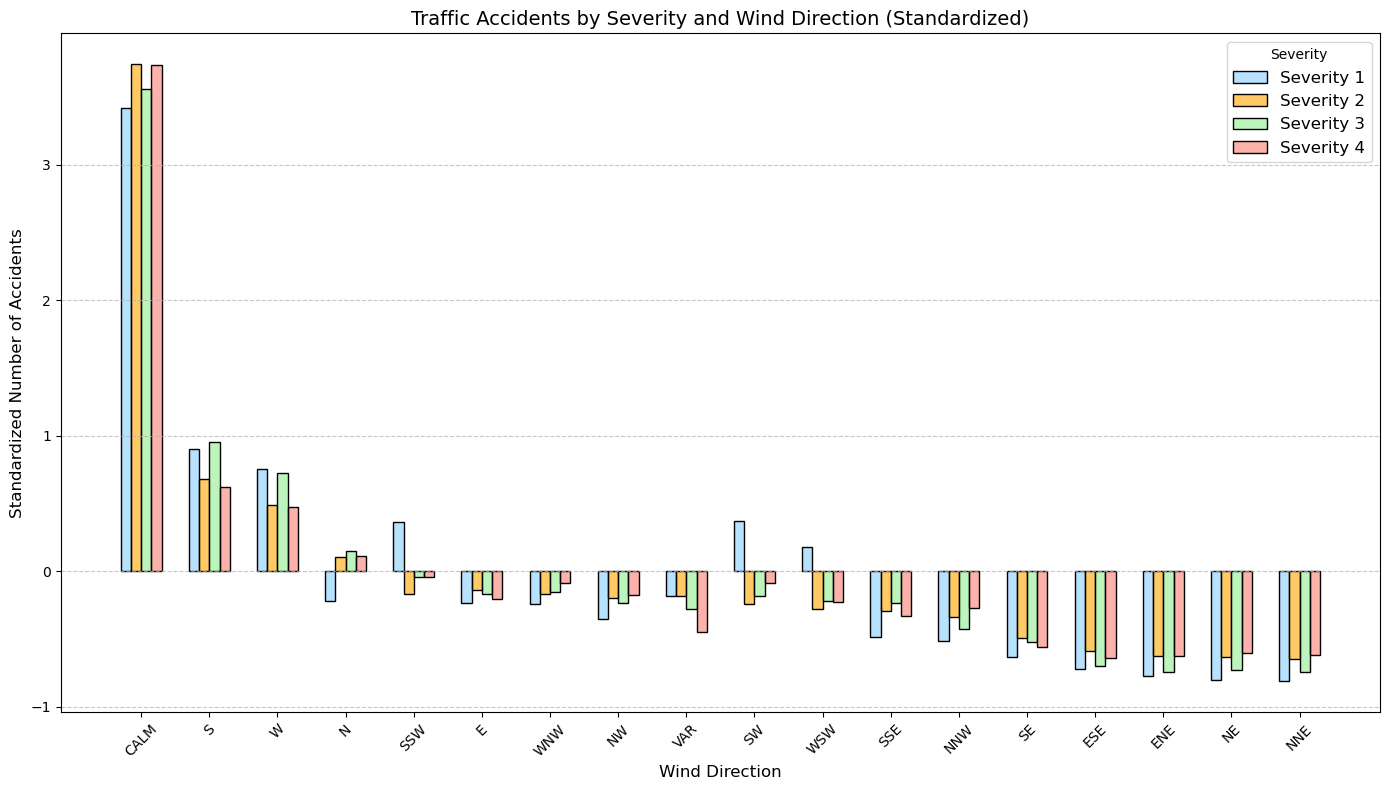

In [49]:
severity_wind_counts = df.groupby(['Wind_Direction', 'Severity']).size().unstack(fill_value=0)

# 对计数进行 Z-score 标准化
standardized_severity_wind_counts = (severity_wind_counts - severity_wind_counts.mean()) / severity_wind_counts.std()

# 按总事故数量对风向进行排序
severity_wind_counts['Total'] = severity_wind_counts.sum(axis=1)
sorted_severity_wind_counts = severity_wind_counts.sort_values(by='Total', ascending=False).drop(columns='Total')
standardized_severity_wind_counts = standardized_severity_wind_counts.loc[sorted_severity_wind_counts.index]

# 绘制柱状图
fig, ax = plt.subplots(figsize=(14, 8))

# 为了给每个严重等级一个单独的柱子，需要调整柱子的位置
width = 0.15  # 每个柱子的宽度
positions = np.arange(len(standardized_severity_wind_counts.index))  # 每个风向的基础位置

# 绘制每个严重等级的柱子
for i, severity in enumerate(standardized_severity_wind_counts.columns):
    ax.bar(positions + i * width, standardized_severity_wind_counts[severity], width=width, label=f'Severity {severity}', color=colors[i], edgecolor='black')

# 添加标题和标签
ax.set_title('Traffic Accidents by Severity and Wind Direction (Standardized)', fontsize=14)
ax.set_xlabel('Wind Direction', fontsize=12)
ax.set_ylabel('Standardized Number of Accidents', fontsize=12)
ax.set_xticks(positions + width * (len(standardized_severity_wind_counts.columns) - 1) / 2)
ax.set_xticklabels(standardized_severity_wind_counts.index, rotation=45)
ax.legend(title='Severity', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

可以看到，在'CALM'的风向情况下，交通事故总数量最多，其次是'S'和'W'南风和西风的风向情况下。其中'CALM'的风向情况下，交通事故总数量远远超过第二名南风的风向情况。

继续调查交通事故发生时各种详细的天气连续性指标情况：

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


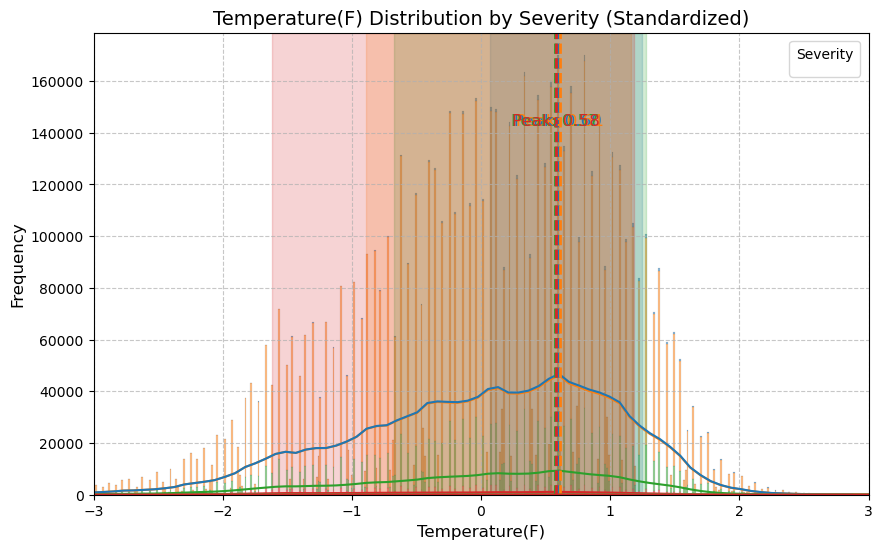

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


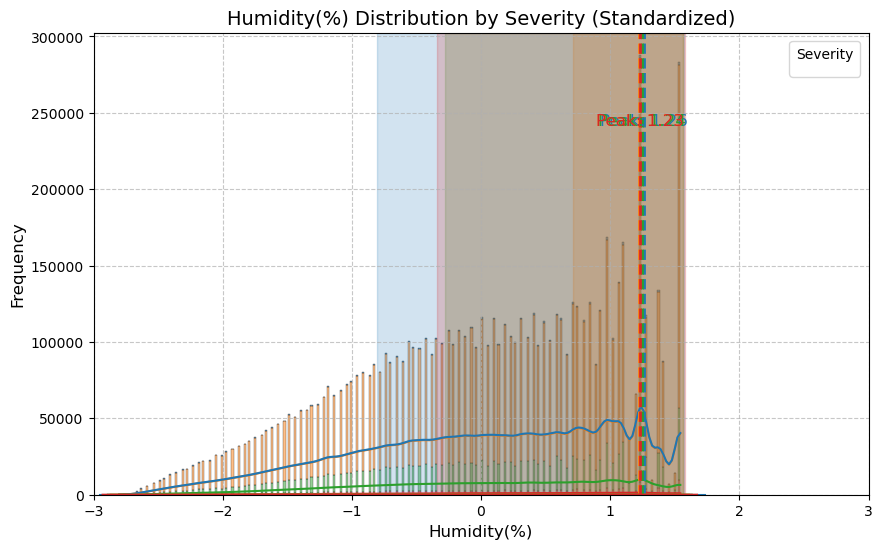

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


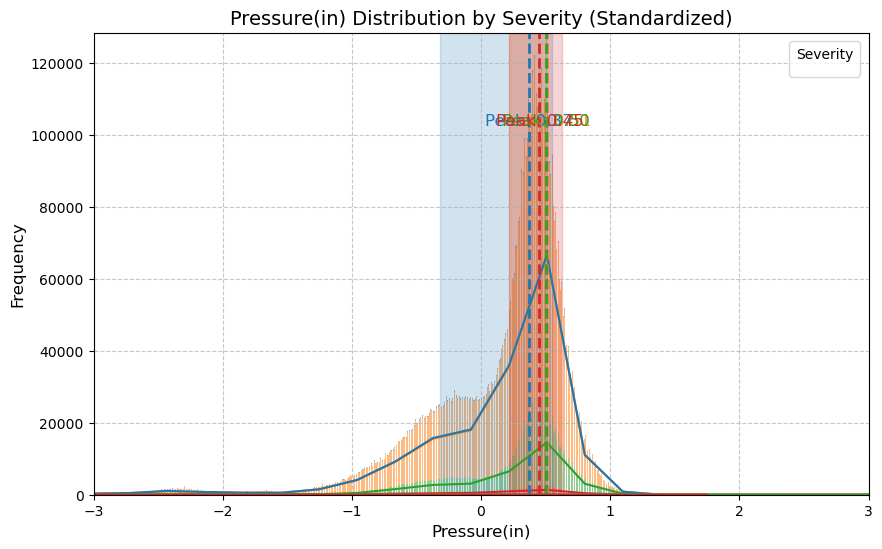

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


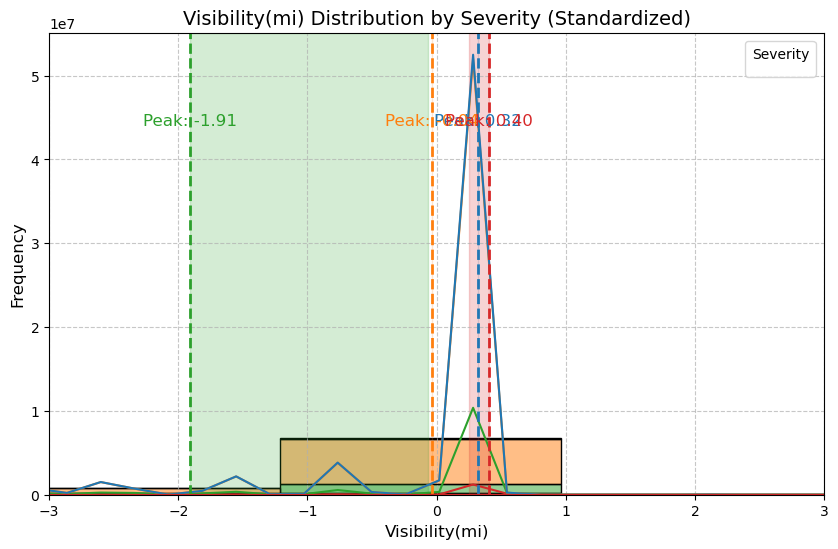

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


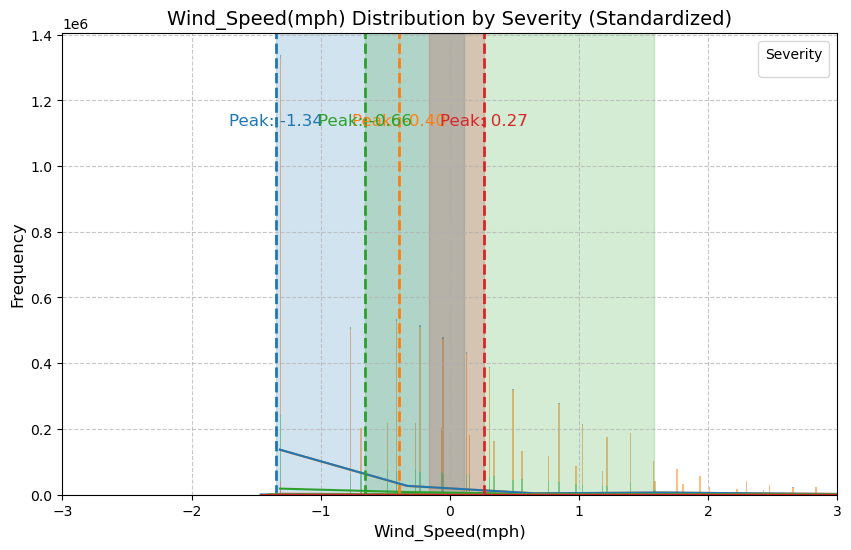

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


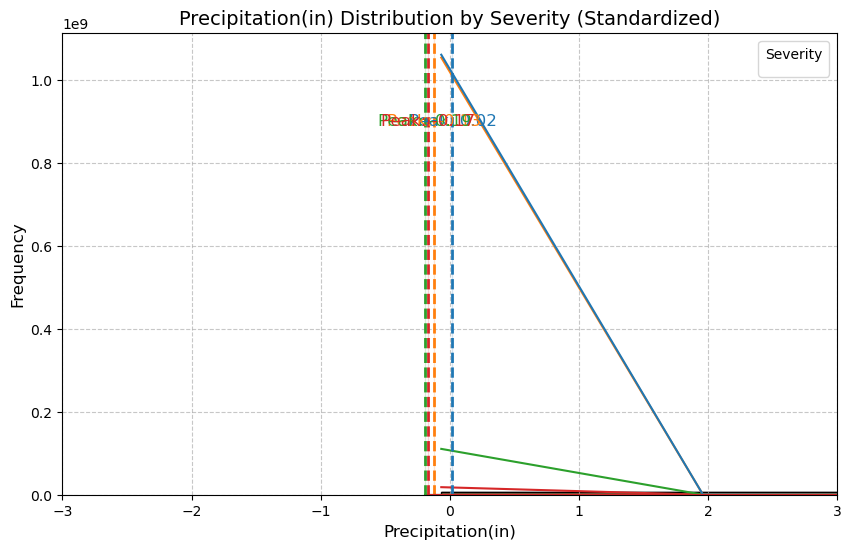


Temperature(F):
Severity 1: Peak Value = 0.60, Range = (0.07, 1.25)
Severity 2: Peak Value = 0.61, Range = (-0.89, 1.16)
Severity 3: Peak Value = 0.57, Range = (-0.68, 1.28)
Severity 4: Peak Value = 0.58, Range = (-1.62, 1.18)

Humidity(%):
Severity 1: Peak Value = 1.26, Range = (-0.81, 1.57)
Severity 2: Peak Value = 1.23, Range = (0.71, 1.56)
Severity 3: Peak Value = 1.24, Range = (-0.28, 1.56)
Severity 4: Peak Value = 1.23, Range = (-0.34, 1.58)

Pressure(in):
Severity 1: Peak Value = 0.37, Range = (-0.31, 0.55)
Severity 2: Peak Value = 0.51, Range = (0.22, 0.51)
Severity 3: Peak Value = 0.50, Range = (0.50, 0.50)
Severity 4: Peak Value = 0.45, Range = (0.22, 0.63)

Visibility(mi):
Severity 1: Peak Value = 0.32, Range = (0.32, 0.32)
Severity 2: Peak Value = -0.04, Range = (-0.04, -0.04)
Severity 3: Peak Value = -1.91, Range = (-1.91, -0.07)
Severity 4: Peak Value = 0.40, Range = (0.25, 0.40)

Wind_Speed(mph):
Severity 1: Peak Value = -1.34, Range = (-1.34, 0.11)
Severity 2: Peak Val

In [50]:
weather_conditions = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']

# 使用 StandardScaler 进行 Z-score 标准化
scaler = StandardScaler()
df[weather_conditions] = scaler.fit_transform(df[weather_conditions])

# 设置存储结果的字典
peak_values = {}
range_values = {}

# 计算每个天气变量在不同严重等级下的分布
for condition in weather_conditions:
    plt.figure(figsize=(10, 6))
    
    hue_order = sorted(df['Severity'].unique())
    
    sns.histplot(data=df, x=condition, hue='Severity', multiple='stack', kde=True, hue_order=hue_order, legend=True)
    
    plt.title(f'{condition} Distribution by Severity (Standardized)', fontsize=14)
    plt.xlabel(condition, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.xlim(-3, 3)  # 标准化后通常数据会在这个范围内
    
    plt.legend(title='Severity', fontsize=12)
    
    # 初始化存储每个严重性级别下的峰值和区间
    peak_values[condition] = {}
    range_values[condition] = {}
    
    # 计算 kde 密度估计
    for severity in hue_order:
        subset = df[df['Severity'] == severity][condition]
        kde = sns.kdeplot(subset, bw_adjust=0.5, label=f'Severity {severity}')
        
        # 找到密度函数的最高点
        peak = kde.get_lines()[-1].get_data()
        peak_idx = np.argmax(peak[1])
        peak_value = peak[0][peak_idx]
        
        # 找到最高频率左右范围
        half_max = peak[1][peak_idx] / 2
        range_mask = (peak[1] >= half_max)
        lower_bound = peak[0][range_mask][0]
        upper_bound = peak[0][range_mask][-1]
        
        # 在图上标出最高频率的区域和范围
        plt.axvline(peak_value, color=kde.get_lines()[-1].get_color(), linestyle='--', linewidth=2)
        plt.axvspan(lower_bound, upper_bound, color=kde.get_lines()[-1].get_color(), alpha=0.2)
        plt.text(peak_value, plt.ylim()[1]*0.8, f'Peak: {peak_value:.2f}', 
                 color=kde.get_lines()[-1].get_color(), fontsize=12, ha='center')
        
        # 保存峰值位置和区间
        peak_values[condition][severity] = peak_value
        range_values[condition][severity] = (lower_bound, upper_bound)

    plt.show()

# 打印结果
for condition, peaks in peak_values.items():
    print(f"\n{condition}:")
    for severity, peak in peaks.items():
        lower_bound, upper_bound = range_values[condition][severity]
        print(f"Severity {severity}: Peak Value = {peak:.2f}, Range = ({lower_bound:.2f}, {upper_bound:.2f})")

### 1.4 数据重采样和特征工程与选择

In [52]:
df = pd.read_csv('data/cleaned_data.csv')

#### 1.4.1 数据重采样

In [53]:
# 1. 找到每个严重等级的数据量
severity_counts = df['Severity'].value_counts()
min_count = severity_counts.min()  # 找到最少的类别的样本数

# 2. 对每个严重等级的数据进行欠采样，使得每个类别的样本数等于最少类别的数量
df_resampled = pd.DataFrame()  # 用于存储采样后的数据

# 按严重等级进行分组并欠采样
for severity in severity_counts.index:
    df_severity = df[df['Severity'] == severity]  # 提取某个严重等级的数据
    df_downsampled = resample(df_severity, 
                              replace=False,  # 不放回采样
                              n_samples=min_count,  # 样本数等于最小类别的样本数
                              random_state=42)  # 保证结果的可重复性
    df_resampled = pd.concat([df_resampled, df_downsampled])

# 3. 查看欠采样后的结果
print(df_resampled['Severity'].value_counts())

Severity
2    66098
3    66098
4    66098
1    66098
Name: count, dtype: int64


In [54]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 264392 entries, 3541104 to 546931
Data columns (total 42 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Severity                      264392 non-null  int64  
 1   Start_Time                    264392 non-null  object 
 2   Start_Lat                     264392 non-null  float64
 3   Start_Lng                     264392 non-null  float64
 4   Distance(mi)                  264392 non-null  float64
 5   Street                        264392 non-null  object 
 6   City                          264392 non-null  object 
 7   County                        264392 non-null  object 
 8   State                         264392 non-null  object 
 9   Zipcode                       264392 non-null  object 
 10  Timezone                      264392 non-null  object 
 11  Airport_Code                  264392 non-null  object 
 12  Temperature(F)                264392 non-nu

继续删除无用的信息，并对分类变量进行独热编码和频率编码：

In [55]:
df_resampled = df_resampled.drop(['Start_Time', 'Distance(mi)'], axis=1)

In [56]:
df_resampled['Severity'] = pd.Categorical(df_resampled['Severity'], categories=[1, 2, 3, 4], ordered=True)

In [57]:
# 列表中包含要进行频率编码的列
features_to_encode = ['City', 'County', 'State', 'Zipcode', 'Timezone', 'Airport_Code']

# 对每个特征进行频率编码
for feature in features_to_encode:
    # 计算每个类别的频率
    frequencies = df_resampled[feature].value_counts()
    
    # 创建频率编码映射字典
    frequency_mapping = frequencies.to_dict()
    
    # 将频率编码应用到数据中
    df_resampled[feature + '_Fre'] = df_resampled[feature].map(frequency_mapping)

# 处理 Minute_of_Day 变量
minute_frequencies = df_resampled['Minute_of_Day'].value_counts()
df_resampled['Minute_of_Day_Fre'] = df_resampled['Minute_of_Day'].map(minute_frequencies)

df_resampled = df_resampled.drop(columns=['City', 'County', 'State', 'Zipcode', 'Timezone', 'Airport_Code', 'Minute_of_Day'])

In [58]:
binary_columns = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

# 进行二值编码
for column in binary_columns:
    df_resampled[column] = df_resampled[column].apply(lambda x: 1 if x == 'day' else 0).astype('bool')

In [59]:
# 定义划分规则的函数
def classify_street_type(street_name):
    # 移除特殊字符
    street_name = re.sub(r'[^\w\s]', ' ', street_name)
    
    # 定义标记
    street_types = []
    
    if 'Road' in street_name or 'Rd' in street_name:
        street_types.append('Rd')
    if 'Avenue' in street_name or 'Ave' in street_name:
        street_types.append('Ave')
    if 'Street' in street_name or 'St' in street_name:
        street_types.append('St')
    if 'Highway' in street_name or 'Hwy' in street_name:
        street_types.append('Highway')
    if 'US' in street_name:
        street_types.append('US')
    if 'I' in street_name:
        street_types.append('I')
    
    # 返回最匹配的类型，若有多个则选择第一个
    return street_types[0] if street_types else 'Other'

# 应用划分规则
df_resampled['Street_Type'] = df_resampled['Street'].apply(classify_street_type)

# 独热编码
df_encoded = pd.get_dummies(df_resampled['Street_Type'], prefix='Street_Type')

# 合并原始数据与编码数据
df_final = pd.concat([df_resampled, df_encoded], axis=1).drop(columns=['Street_Type'])

In [60]:
# 对 'Wind_Direction' 进行独热编码
df_wind_encoded = pd.get_dummies(df_final['Wind_Direction'], prefix='Wind_Direction')

# 对 'Weather_Condition_Simplified' 进行独热编码
df_weather_encoded = pd.get_dummies(df_final['Weather_Condition_Simplified'], prefix='Weather_Condition')

# 将独热编码后的列添加到原始数据中
df_final = pd.concat([df_final, df_wind_encoded, df_weather_encoded], axis=1)

# 删除原始的类别列
df_final.drop(['Street', 'Wind_Direction', 'Weather_Condition_Simplified'], axis=1, inplace=True)

In [61]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 264392 entries, 3541104 to 546931
Data columns (total 73 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   Severity                      264392 non-null  category
 1   Start_Lat                     264392 non-null  float64 
 2   Start_Lng                     264392 non-null  float64 
 3   Temperature(F)                264392 non-null  float64 
 4   Humidity(%)                   264392 non-null  float64 
 5   Pressure(in)                  264392 non-null  float64 
 6   Visibility(mi)                264392 non-null  float64 
 7   Wind_Speed(mph)               264392 non-null  float64 
 8   Precipitation(in)             264392 non-null  float64 
 9   Amenity                       264392 non-null  bool    
 10  Bump                          264392 non-null  bool    
 11  Crossing                      264392 non-null  bool    
 12  Give_Way                     

可以看到目前变量太多了，因此之后进行特征选择，删除一些冗余特征，方便之后机器模型的学习和预测。

#### 1.4.2 特征选择

由于要研究的目标变量是交通事故的严重性，分为四种，1级，2级，3级，4级，并且严重性是有递增顺序的，因此这是有序分类变量。于是对于目标变量与特征的相关性，这里我们需要分开讨论。一种是有序分类变量和无序分类变量的相关性，例如（天气情况，道路种类，POI信息）等，一种是有序分类变量和连续变量的相关性，例如天气详细特征，温度，湿度，风速等。

关于有序分类变量和无序分类变量，这里采用卡方检验来检查相关性。

In [62]:
results = []

# 列出所有布尔型变量
boolean_columns = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
    'Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
    'Astronomical_Twilight', 'Street_Type_Ave', 'Street_Type_Highway',
    'Street_Type_I', 'Street_Type_Other', 'Street_Type_Rd',
    'Street_Type_St', 'Street_Type_US', 'Wind_Direction_CALM',
    'Wind_Direction_E', 'Wind_Direction_ENE', 'Wind_Direction_ESE',
    'Wind_Direction_N', 'Wind_Direction_NE', 'Wind_Direction_NNE',
    'Wind_Direction_NNW', 'Wind_Direction_NW', 'Wind_Direction_S',
    'Wind_Direction_SE', 'Wind_Direction_SSE', 'Wind_Direction_SSW',
    'Wind_Direction_SW', 'Wind_Direction_VAR', 'Wind_Direction_W',
    'Wind_Direction_WNW', 'Wind_Direction_WSW', 'Weather_Condition_Clear',
    'Weather_Condition_Cloudy', 'Weather_Condition_Dust', 'Weather_Condition_Fog',
    'Weather_Condition_Heavy_rain', 'Weather_Condition_Heavy_snow',
    'Weather_Condition_Ice', 'Weather_Condition_Rain', 'Weather_Condition_Snow',
    'Weather_Condition_Storm', 'Weather_Condition_Thunder'
]

# 对每个布尔型变量进行卡方检验
for column in boolean_columns:
    # 创建列联表
    contingency_table = pd.crosstab(df_final['Severity'], df_final[column])
    
    # 计算卡方统计量和 p-value
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # 存储结果
    results.append({'Variable': column, 'Chi2': chi2, 'p-value': p})

# 将结果转换为 DataFrame
results_df = pd.DataFrame(results).sort_values(by='p-value')

# 查看排序后的结果
print(results_df)

# 添加从1开始的指引列
results_df.insert(0, 'Index', range(1, len(results_df) + 1))

# 保存到CSV文件
csv_file_path = 'data/chi_square_results.csv'
results_df.to_csv(csv_file_path, index=False)

                        Variable          Chi2        p-value
20                Street_Type_Rd   8864.096589   0.000000e+00
21                Street_Type_St   2189.737567   0.000000e+00
18                 Street_Type_I  30594.552332   0.000000e+00
17           Street_Type_Highway   5739.982649   0.000000e+00
16               Street_Type_Ave   3952.389331   0.000000e+00
11                Traffic_Signal  28930.286050   0.000000e+00
9                           Stop   1551.030004   0.000000e+00
8                        Station   1843.269923   0.000000e+00
41       Weather_Condition_Clear   2770.079103   0.000000e+00
49        Weather_Condition_Snow   1641.975400   0.000000e+00
2                       Crossing  20573.801873   0.000000e+00
4                       Junction   2006.949355   0.000000e+00
19             Street_Type_Other   1250.697064  7.335777e-271
22                Street_Type_US   1054.649097  2.510520e-228
42      Weather_Condition_Cloudy    976.056560  2.812761e-211
0       

可以看到，卡方统计量显示，道路类型分类变量与交通事故严重性的相关程度很大，并且p值很高，这表明了这些变量与目标变量之间的关系非常显著。而不同计时方法白天与夜晚的划分其和目标变量之间没有显示出显著的统计关联，意味着这些变量可能对严重性的影响不大，因此可以直接删除。

由于分类变量总共有52个，因此这里为了减少特征，以1e-10为阈值，删除p值大于这个阈值的特征。这样可以减少计算复杂度，同时避免模型过拟合。

In [63]:
# 设置阈值
p_value_threshold = 1e-10

# 提取 p 值大于阈值的变量名
high_p_value_vars = results_df[results_df['p-value'] > p_value_threshold]['Variable']

# 删除这些变量列
df_final = df_final.drop(columns=high_p_value_vars)

接着使用Spearman秩相关系数检查有序分类变量和连续变量之间的相关性：

In [64]:
# 选择需要分析的变量
variables = [
    'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
    'Wind_Speed(mph)', 'Precipitation(in)', 'Year', 'Month', 'Day_of_Year',
    'Weekday', 'Hour', 'City_Fre', 'County_Fre', 'State_Fre', 'Zipcode_Fre',
    'Timezone_Fre', 'Airport_Code_Fre', 'Minute_of_Day_Fre'
]

# 创建结果列表
results = []

# 对每个变量进行 Spearman 相关性分析
for var in variables:
    correlation, p_value = spearmanr(df_final['Severity'], df_final[var])
    results.append({'Variable': var, 'Spearman Correlation': correlation, 'p-value': p_value})

# 将结果转换为 DataFrame
results_df = pd.DataFrame(results)

# 根据 Spearman 相关系数的绝对值排序
results_df = results_df.sort_values(by='Spearman Correlation', key=abs, ascending=False)

# 查看结果
print(results_df)

# 添加从1开始的指引列
results_df.insert(0, 'Index', range(1, len(results_df) + 1))

# 保存到CSV文件
csv_file_path = 'data/Spearman_Correlation_results.csv'
results_df.to_csv(csv_file_path, index=False)

             Variable  Spearman Correlation        p-value
6                Year             -0.347598   0.000000e+00
16   Airport_Code_Fre             -0.264764   0.000000e+00
11           City_Fre             -0.259303   0.000000e+00
12         County_Fre             -0.256691   0.000000e+00
0      Temperature(F)             -0.243752   0.000000e+00
17  Minute_of_Day_Fre             -0.192697   0.000000e+00
2        Pressure(in)              0.167101   0.000000e+00
13          State_Fre             -0.158516   0.000000e+00
15       Timezone_Fre              0.103232   0.000000e+00
9             Weekday              0.090706   0.000000e+00
10               Hour              0.080414   0.000000e+00
7               Month              0.071261  1.123008e-294
8         Day_of_Year              0.070023  1.408102e-284
3      Visibility(mi)             -0.061780  7.183022e-222
1         Humidity(%)              0.060538  4.110590e-213
5   Precipitation(in)              0.034071   9.359868e-

可以看到Spearman秩相关性分析结果，其中只有风速该连续变量与交通事故严重性的相关性不大，且关系不显著。因此可以直接删除。而年份，气象站台频率，城市频率，县频率，气温等都出现了强烈的负相关，且p值非常小，表示关系非常显著。

因此，这里直接删除'Wind_Speed(mph)'该连续变量。

In [65]:
df_final = df_final.drop(['Wind_Speed(mph)'], axis=1)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 264392 entries, 3541104 to 546931
Data columns (total 51 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   Severity                      264392 non-null  category
 1   Start_Lat                     264392 non-null  float64 
 2   Start_Lng                     264392 non-null  float64 
 3   Temperature(F)                264392 non-null  float64 
 4   Humidity(%)                   264392 non-null  float64 
 5   Pressure(in)                  264392 non-null  float64 
 6   Visibility(mi)                264392 non-null  float64 
 7   Precipitation(in)             264392 non-null  float64 
 8   Amenity                       264392 non-null  bool    
 9   Crossing                      264392 non-null  bool    
 10  Give_Way                      264392 non-null  bool    
 11  Junction                      264392 non-null  bool    
 12  No_Exit                      

In [66]:
df_final.to_csv('data/final_data.csv', index=False)

## 2. 对交通事故的空间分析 

In [67]:
df = pd.read_csv('data/final_data.csv')

由于原始数据是一个一个独立的交通事故点数据，因此如果要分析交通事故在空间上的特征，需要将其在空间网格中聚集，这样才能探寻出其在空间上的分布和相关趋势。

因此，首先将研究范围（美国的49个州）划分为一个一个单独的网格并进行边界地图和网格可视化。

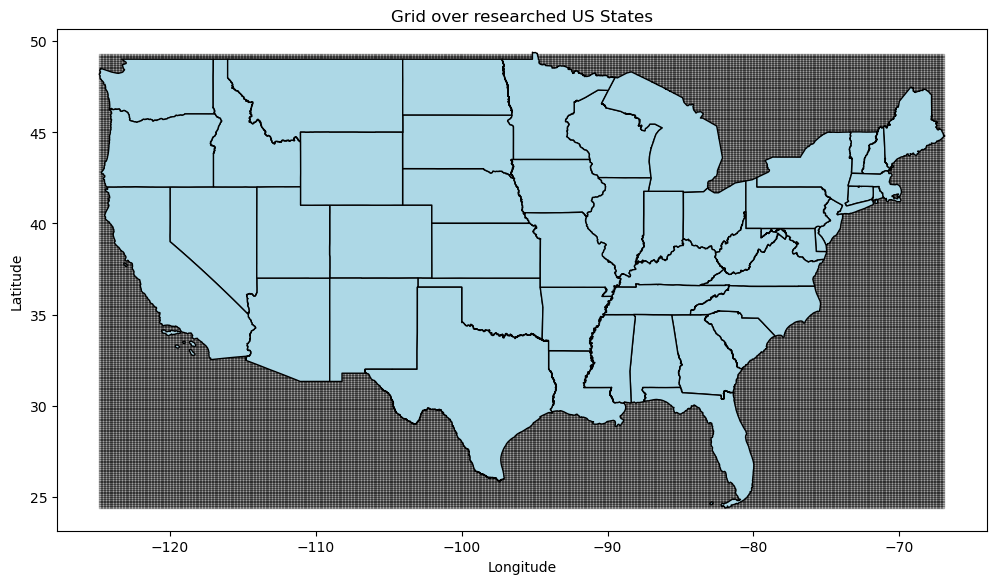

In [69]:
boundary = gpd.read_file('data/us-state-boundaries.geojson')
us_states = ['Ohio', 'West Virginia', 'California', 'Florida', 'Georgia', 'South Carolina', 
             'Nebraska', 'Iowa', 'Illinois', 'Missouri', 'Wisconsin', 'Indiana', 'Michigan', 
             'New Jersey', 'New York', 'Connecticut', 'Massachusetts', 'Rhode Island', 
             'New Hampshire', 'Pennsylvania', 'Kentucky', 'Maryland', 'Virginia', 
             'District of Columbia', 'Delaware', 'Texas', 'Washington', 'Oregon', 'Alabama', 
             'North Carolina', 'Arizona', 'Tennessee', 'Louisiana', 'Minnesota', 'Colorado',
             'Oklahoma', 'Nevada', 'Utah', 'Kansas', 'New Mexico', 'Arkansas', 'Mississippi', 
             'Maine', 'Vermont', 'Wyoming', 'Idaho', 'North Dakota', 'Montana', 'South Dakota']

# 过滤 GeoDataFrame 只保留美国本土大陆的州
filtered_boundary = boundary[boundary['name'].isin(us_states)]
filtered_boundary = filtered_boundary.to_crs('EPSG:4326')

# 获取过滤后数据的边界
xmin, ymin, xmax, ymax = filtered_boundary.total_bounds
grid_size = 0.1  # 网格大小（单位：度）

# 创建网格
grid_cells = []
for x in range(int((xmax - xmin) / grid_size)):
    for y in range(int((ymax - ymin) / grid_size)):
        grid_cells.append(box(xmin + x * grid_size, ymin + y * grid_size, xmin + (x + 1) * grid_size, ymin + (y + 1) * grid_size))

# 创建网格 GeoDataFrame
grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs='EPSG:4326')

# 可视化网格和州边界
fig, ax = plt.subplots(figsize=(12, 12))

# 绘制网格
grid_gdf.plot(ax=ax, edgecolor='black', facecolor='none', alpha=0.3)

# 绘制州边界
filtered_boundary.plot(ax=ax, edgecolor='black', facecolor='lightblue')

plt.title('Grid over researched US States')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

将原始交通事故数据发生位置的经纬度转换为地理信息。

In [70]:
# 创建GeoDataFrame
geometry = [Point(xy) for xy in zip(df['Start_Lng'], df['Start_Lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

之后计算每个网格内不同严重等级的交通事故数量，并将其与网格数据结合在一起。

In [71]:
# 1. 将交通事故数据与网格进行空间连接
joined = gpd.sjoin(gdf, grid_gdf, how='left', op='within')

# 2. 统计每个网格内每种严重等级的事故数量
severity_counts = joined.groupby(['index_right', 'Severity']).size().unstack(fill_value=0)

# 3. 创建一个包含所有网格编号的 DataFrame
all_grid_indices = pd.DataFrame({'index_right': grid_gdf.index})

# 4. 将所有网格编号与统计结果合并，缺失的网格事故数量填充为 0
severity_counts_full = pd.merge(all_grid_indices, severity_counts, how='left', on='index_right').fillna(0)

# 1. 重置 grid_gdf 的索引，确保索引被保存为一列 'index'
grid_gdf = grid_gdf.reset_index()

# 2. 将事故统计结果与网格数据合并
merged_gdf = pd.merge(grid_gdf, severity_counts_full, left_on='index', right_on='index_right', how='left')

# 3. 删除不必要的列，例如 'index_right'
merged_gdf = merged_gdf.drop(columns=['index_right','index'])
severity_counts_full = severity_counts_full.drop(columns=['index_right']) 

# 4. 确保合并后的结果仍然是一个 GeoDataFrame
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry', crs=grid_gdf.crs)

D:\program\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


根据交通事故不同严重等级，分别计算 Gi* 值。

In [72]:
# 选择 KNN 的 k 值
k = 30  # 根据数据规模和计算资源设置
w = KNN.from_dataframe(merged_gdf, k=k)
w.transform = 'r'  # 确保权重矩阵是稀疏的

# 计算 Getis-Ord Gi* 值
gi_star_values = {}
for severity in severity_counts_full.columns:
    # 获取每个网格单元内的该严重等级事故数量
    accidents_count = merged_gdf[severity].values
    
    # 使用 G_Local 进行局部 Getis-Ord Gi* 分析
    g = G_Local(accidents_count, w)
    
    # 将 Gi* 值存储到字典中，使用 Zs 属性存储标准化的 Gi* 值
    gi_star_values[severity] = g.Zs  # Zs 是标准化的 Gi* 统计量

# 将 Gi* 值添加到 merged_gdf
for severity in severity_counts_full.columns:
    merged_gdf[f'Gi_star_{severity}'] = gi_star_values[severity]

将不同严重性等级的Gi* 值热点地图显示在研究范围上，同时显示州与州之间的边界和名称。

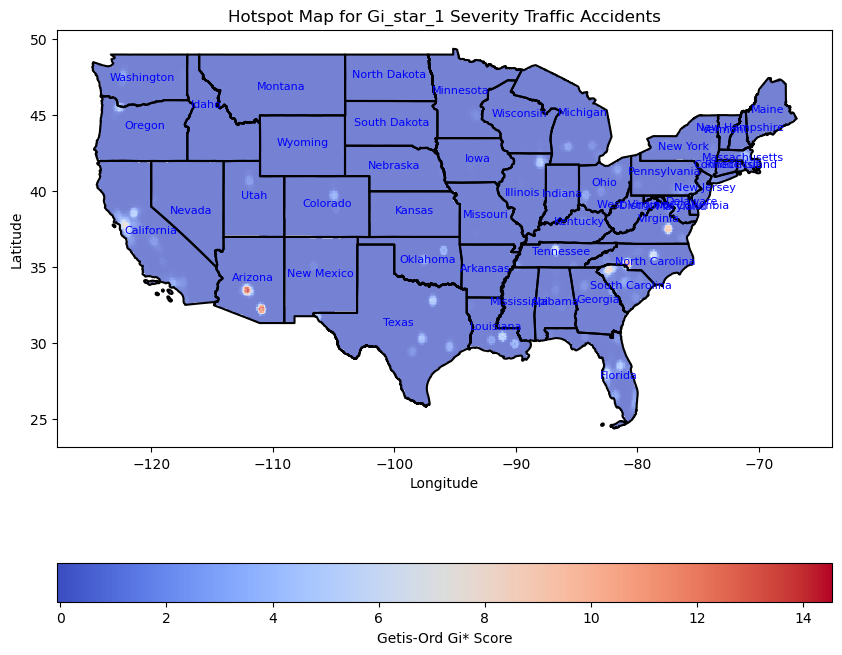

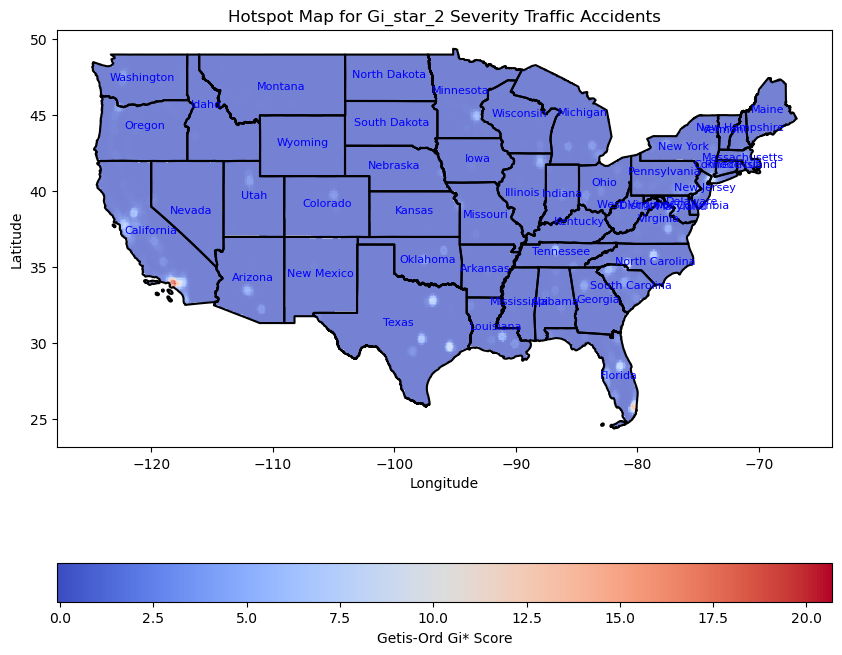

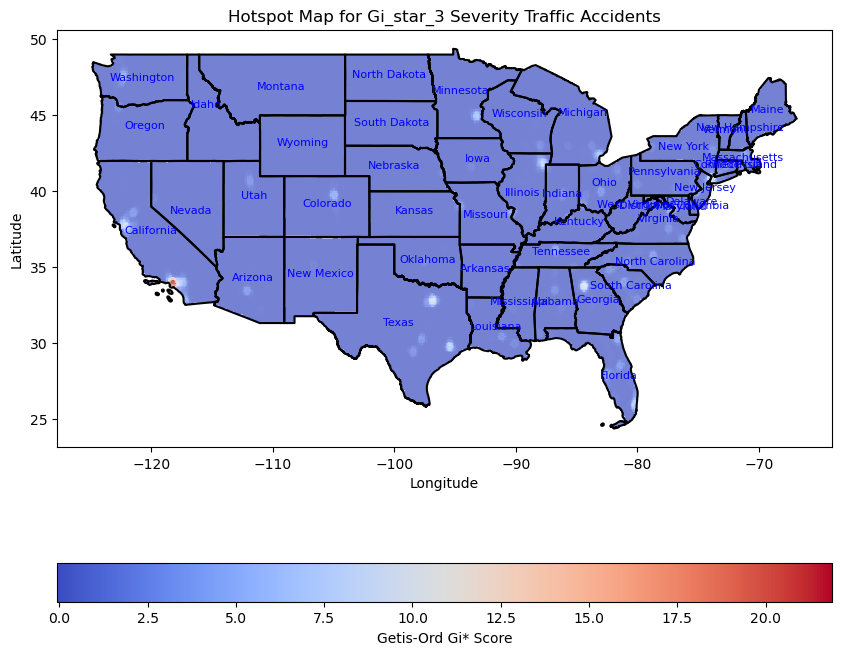

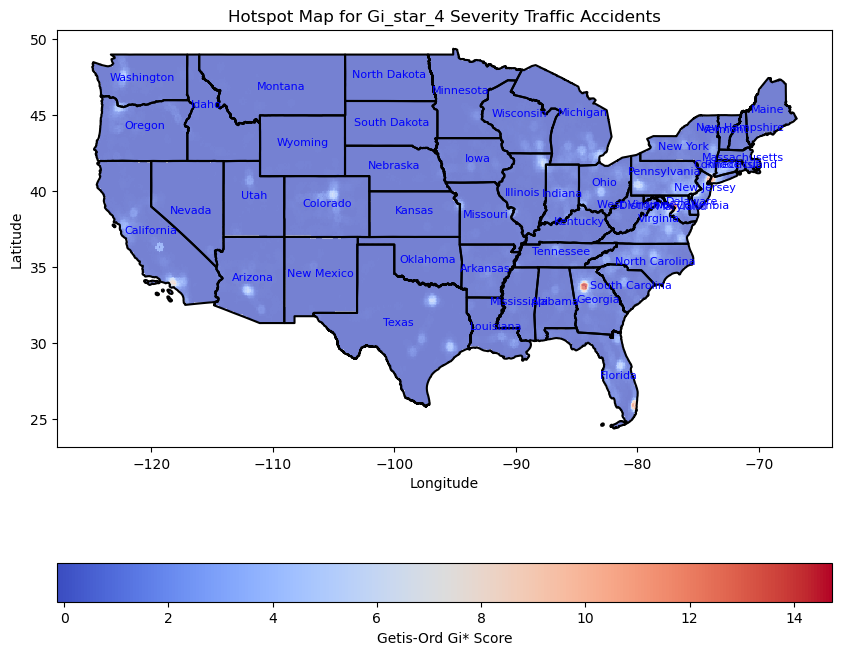

In [73]:
def plot_gi_star_hotspots(merged_gdf, boundary_gdf, severity_col):
    fig, ax = plt.subplots(figsize=(10, 10))

    # 将热点数据裁剪到边界范围内
    clipped_gdf = gpd.clip(merged_gdf, boundary_gdf)

    # 绘制 Gi* 值的热点地图，设置颜色渐变和透明度
    clipped_gdf.plot(column=severity_col, ax=ax, cmap='coolwarm', legend=True, alpha=0.7,
                     legend_kwds={'label': "Getis-Ord Gi* Score",
                                  'orientation': "horizontal"})

    # 绘制边界地图，调整边界线的颜色和宽度
    boundary_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5)

    # 获取每个州的几何中心，用于放置州名标签
    boundary_gdf['coords'] = boundary_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    boundary_gdf['coords'] = [coords[0] for coords in boundary_gdf['coords']]

    # 为每个州添加名字标签
    for _, row in boundary_gdf.iterrows():
        plt.annotate(text=row['name'], xy=row['coords'], horizontalalignment='center', fontsize=8, color='blue')

    # 添加标题
    plt.title(f'Hotspot Map for {severity_col} Severity Traffic Accidents')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.show()

# 为每个严重等级绘制热点图
severity_levels = severity_counts_full.columns
for severity in severity_levels:
    plot_gi_star_hotspots(merged_gdf, filtered_boundary, f'Gi_star_{severity}')

根据不同严重性等级交通事故热点地图的显示，可以看到1级交通事故其在Arizona, California, South Carolina, North Carolina, Virginia这几个州显示出了比较明显的热点。而2级交通事故其只在California和Florida这两个州有比较显著的热点聚集。之后关于3级交通事故，其只在California州的南部有显著热点聚集。最后是关于4级交通事故，其在Georgia州的西北部有一处非常明显的热点聚集，然后在California和Florida这两个州有两处小小的热点聚集。不同严重性等级的交通事故虽然在Texas州没有明显的热点聚集显示，但是该州有一些明显且固定的聚集点。此外，可以看到，随着事故严重性的增加，除了California州，越来越多的热点聚集在美国的东部地区。不过综合来看，不同严重性等级的交通事故其热点趋势并不明显，无论什么严重等级都只有几处显著的热点聚集，其中1级事故的热点最多，3级事故的热点最少。不同严重等级事故热点聚集分布的州不太相同，但共同的州是California。

将Gi*值与原交通事故点数据结合在一起，方便之后的预测。

In [74]:
df_gi= gpd.sjoin(gdf, merged_gdf, how='left', op='within')

D:\program\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


对添加了Gi* 值的数据进行一些处理并保存到文件。

In [75]:
df_gi = df_gi.rename(columns={
    1: 'Severity_number_1',
    2: 'Severity_number_2',
    3: 'Severity_number_3',
    4: 'Severity_number_4'
})

df_gi = df_gi.dropna(subset=['Gi_star_1', 'Gi_star_2', 'Gi_star_3', 'Gi_star_4',
                             'Severity_number_1', 'Severity_number_2', 'Severity_number_3', 'Severity_number_4'])

df_gi = df_gi.drop(columns=['index_right', 'geometry'])

df_gi.to_csv('data/data_with_gi.csv', index=False)

## 3.对交通事故严重性进行预测

### 3.1 原始数据和基础随机森林

首先采用最基础的随机森林对没有添加Gi* 值空间特征的交通事故数据进行严重性分类预测。

In [78]:
df = pd.read_csv('data/final_data.csv')

# 将布尔值列转换为整数（0或1）
bool_columns = df.select_dtypes(include='bool').columns
df[bool_columns] = df[bool_columns].astype(int)

# 特征列
X = df.drop(columns=['Severity'])

# 目标列
y = df['Severity']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 创建和训练随机森林模型
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = rf.predict(X_test)

# 评估模型性能
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # 加权平均精确度
recall = recall_score(y_test, y_pred, average='weighted')  # 加权平均召回率
f1 = f1_score(y_test, y_pred, average='weighted')  # 加权平均F1得分

# 打印评估结果
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# 打印详细分类报告
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.75
Precision: 0.75
Recall: 0.75
F1 Score: 0.75
Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.95      0.92     19980
           2       0.70      0.64      0.67     19777
           3       0.70      0.74      0.72     19753
           4       0.70      0.67      0.69     19808

    accuracy                           0.75     79318
   macro avg       0.75      0.75      0.75     79318
weighted avg       0.75      0.75      0.75     79318



使用贝叶斯优化寻找随机森林模型最优参数并使用寻找到的最优参数进行预测并评估模型。

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 定义超参数空间
param_space = [
    Integer(100, 300, name='n_estimators'),           # 树的数量
    Integer(10, 30, name='max_depth'),                # 最大深度
    Integer(5, 15, name='min_samples_split'),         # 分裂所需的最小样本数
    Integer(5, 10, name='min_samples_leaf'),          # 叶子节点的最小样本数
    Categorical(['sqrt', 'log2', None], name='max_features'),  # 每次分裂考虑的特征数量
    Categorical([True, False], name='bootstrap')      # 是否使用自助法
]

# 目标函数
@use_named_args(param_space)
def objective(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, bootstrap):
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )
    # 使用5折交叉验证评估模型性能
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return -score  # 贝叶斯优化通常最小化目标函数，所以取负值以最大化准确率

# 执行贝叶斯优化
results = gp_minimize(
    func=objective,
    dimensions=param_space,
    n_calls=10,  # 调整为适合你的计算资源
    random_state=42
)

# 查看最佳参数和得分
best_params = results.x
best_score = -results.fun  # 由于目标函数取负值，所以需要取负值以恢复准确率
print("最佳参数：", best_params)
print("最佳得分：", best_score)

# 使用最佳参数训练最终模型
best_rf = RandomForestClassifier(
    n_estimators=best_params[0],
    max_depth=best_params[1],
    min_samples_split=best_params[2],
    min_samples_leaf=best_params[3],
    max_features=best_params[4],
    bootstrap=best_params[5],
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = best_rf.predict(X_test)

# 评估模型性能
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 打印评估结果
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# 打印详细分类报告
print('Classification Report:')
print(classification_report(y_test, y_pred))

显示在随机森林预测过程中特征的重要性排名。

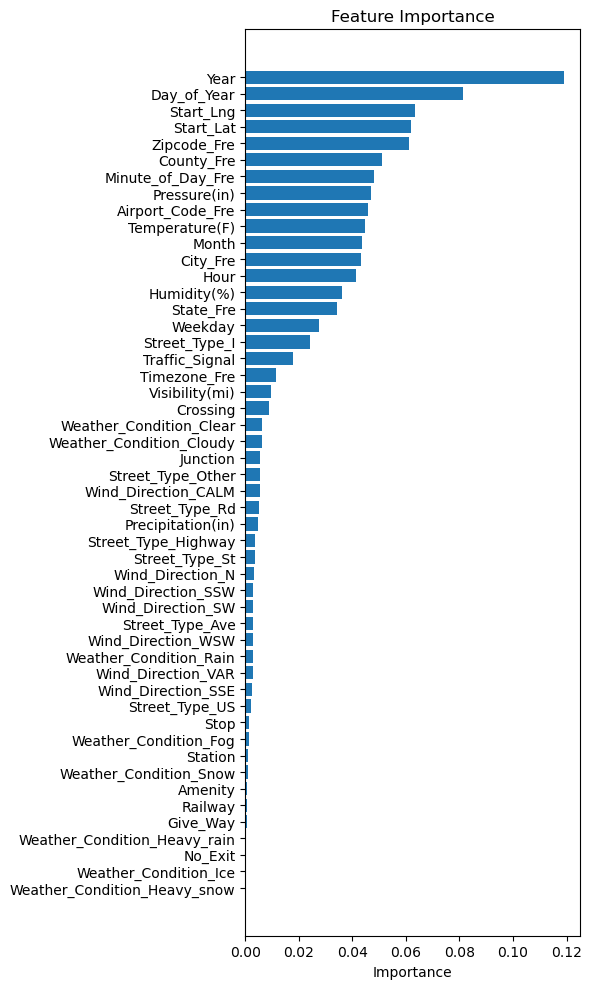

In [80]:
# 获取特征重要性
importances = best_rf.feature_importances_

# 获取特征名称并按重要性排序
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# 可视化特征重要性
plt.figure(figsize=(6, 10))
plt.title("Feature Importance")

# 绘制水平条形图
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), feature_names[indices])  # 使用特征名称作为纵坐标标签

plt.xlabel('Importance')
plt.tight_layout()
plt.gca().invert_yaxis()  # 使重要性从上到下排序
plt.show()

### 3.2 添加新空间特征预测

接着使用添加了Gi* 值空间特征的新数据集和基础随机森林模型进行预测：

In [81]:
df_gi = pd.read_csv('data/data_with_gi.csv')

# 将布尔值列转换为整数（0或1）
bool_columns = df_gi.select_dtypes(include='bool').columns
df_gi[bool_columns] = df_gi[bool_columns].astype(int)

# 特征列
X = df_gi.drop(columns=['Severity'])

# 目标列
y = df_gi['Severity']

In [82]:
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 创建和训练随机森林模型
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = rf.predict(X_test)

# 评估模型性能
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # 加权平均精确度
recall = recall_score(y_test, y_pred, average='weighted')  # 加权平均召回率
f1 = f1_score(y_test, y_pred, average='weighted')  # 加权平均F1得分

# 打印评估结果
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# 打印详细分类报告
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1 Score: 0.77
Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.94      0.92     19980
           2       0.71      0.68      0.70     19777
           3       0.71      0.77      0.74     19753
           4       0.75      0.68      0.71     19808

    accuracy                           0.77     79318
   macro avg       0.77      0.77      0.77     79318
weighted avg       0.77      0.77      0.77     79318



继续使用贝叶斯优化参数，并使用最优参数进行预测。

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 定义超参数空间
param_space = [
    Integer(100, 300, name='n_estimators'),           # 树的数量
    Integer(10, 30, name='max_depth'),                # 最大深度
    Integer(5, 15, name='min_samples_split'),         # 分裂所需的最小样本数
    Integer(5, 10, name='min_samples_leaf'),          # 叶子节点的最小样本数
    Categorical(['sqrt', 'log2', None], name='max_features'),  # 每次分裂考虑的特征数量
    Categorical([True, False], name='bootstrap')      # 是否使用自助法
]

# 目标函数
@use_named_args(param_space)
def objective(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, bootstrap):
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )
    # 使用5折交叉验证评估模型性能
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return -score  # 贝叶斯优化通常最小化目标函数，所以取负值以最大化准确率

# 执行贝叶斯优化
results = gp_minimize(
    func=objective,
    dimensions=param_space,
    n_calls=10,  # 调整为适合你的计算资源
    random_state=42
)

# 查看最佳参数和得分
best_params = results.x
best_score = -results.fun  # 由于目标函数取负值，所以需要取负值以恢复准确率
print("最佳参数：", best_params)
print("最佳得分：", best_score)

# 使用最佳参数训练最终模型
best_rf = RandomForestClassifier(
    n_estimators=best_params[0],
    max_depth=best_params[1],
    min_samples_split=best_params[2],
    min_samples_leaf=best_params[3],
    max_features=best_params[4],
    bootstrap=best_params[5],
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = best_rf.predict(X_test)

# 评估模型性能
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 打印评估结果
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# 打印详细分类报告
print('Classification Report:')
print(classification_report(y_test, y_pred))

显示特征重要性排名：

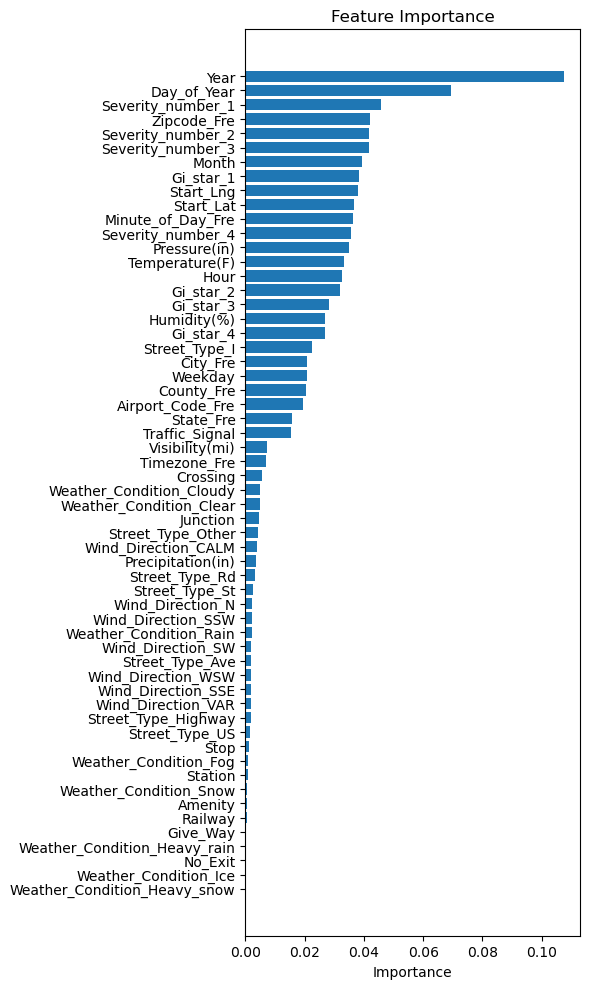

In [83]:
# 获取特征重要性
importances = rf.feature_importances_

# 获取特征名称并按重要性排序
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# 可视化特征重要性
plt.figure(figsize=(6, 10))
plt.title("Feature Importance")

# 绘制水平条形图
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), feature_names[indices])  # 使用特征名称作为纵坐标标签

plt.xlabel('Importance')
plt.tight_layout()
plt.gca().invert_yaxis()  # 使重要性从上到下排序
plt.show()

空间加权随机森林对添加了Gi* 值空间特征的新数据集进行预测：

In [82]:
def compute_spatial_weights(coords, method='idw', p=2, sigma=1.0, k_neighbors=50):
    """
    计算空间权重矩阵，仅考虑每个样本的 k 个最近邻居。
    coords: 样本的空间坐标 (经纬度)
    method: 空间权重方法 ('idw', 'gaussian')
    p: 距离衰减参数（用于 IDW）
    sigma: 高斯核的带宽参数（用于高斯核权重）
    k_neighbors: 每个样本考虑的最近邻居数量
    """
    tree = BallTree(coords, metric='haversine')  # 使用Haversine距离构建空间树
    dists, indices = tree.query(coords, k=k_neighbors)  # 查询前 k 个邻居的距离和索引
    
    if method == 'idw':
        weights = 1 / (dists ** p)
    elif method == 'gaussian':
        weights = np.exp(-dists**2 / (2 * sigma**2))
    
    # 处理除零问题：将无穷大值替换为零
    weights[~np.isfinite(weights)] = 0
    
    # 归一化权重，避免出现 NaN
    weights_sum = weights.sum(axis=1, keepdims=True)
    weights_sum[weights_sum == 0] = 1  # 避免除零
    weights /= weights_sum
    
    return weights, indices

def spatially_weighted_random_forest(X, y, coords, method='idw', n_estimators=100, k_neighbors=50):
    """
    使用空间加权的随机森林分类模型进行训练。
    X: 样本的特征矩阵
    y: 目标变量
    coords: 样本的空间坐标 (经纬度)
    method: 空间权重方法 ('idw', 'gaussian')
    n_estimators: 随机森林中树的数量
    k_neighbors: 每个样本考虑的最近邻居数量
    """
    # 计算空间权重
    weights, indices = compute_spatial_weights(coords, method=method, k_neighbors=k_neighbors)
    
    # 初始化随机森林分类器
    rf = RandomForestClassifier(n_estimators=n_estimators)
    
    # 为每个样本分配空间权重，确保使用整数索引而不是 Pandas 默认索引
    sample_weights = np.array([weights[i].dot(y.iloc[indices[i]]) for i in range(len(X))])
    
    # 处理 NaN 值
    sample_weights[np.isnan(sample_weights)] = 0  # 将 NaN 替换为 0
    
    # 训练随机森林模型
    rf.fit(X, y, sample_weight=sample_weights)
    
    return rf 

In [83]:
coords = df_gi[['Start_Lat', 'Start_Lng']].values * np.pi / 180

X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(X, y, coords, test_size=0.3, random_state=42)

rf_model = spatially_weighted_random_forest(X_train, y_train, coords_train, method='idw', n_estimators=100, k_neighbors=50)

# 使用训练好的模型进行预测
y_pred = rf_model.predict(X_test)

# 评估模型性能
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # 加权平均精确度
recall = recall_score(y_test, y_pred, average='weighted')  # 加权平均召回率
f1 = f1_score(y_test, y_pred, average='weighted')  # 加权平均F1得分

# 打印评估结果
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# 打印详细分类报告
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1 Score: 0.77
Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.94      0.92     19980
           2       0.72      0.68      0.70     19777
           3       0.71      0.77      0.74     19753
           4       0.75      0.68      0.71     19808

    accuracy                           0.77     79318
   macro avg       0.77      0.77      0.77     79318
weighted avg       0.77      0.77      0.77     79318

